In [165]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
import argparse

# Données
import wrds

# V3
import yfinance as yf

# Synthèse de l'Analyse en Composantes Principales

L'analyse en composantes principales (ACP) a été réalisée manuellement sur les rendements logarithmiques mensuels de cinq devises (AUD, CAD, JPY, CHF, GBP) contre USD sur la période 2006-2024 (227 observations). Les données ont été préalablement standardisées (centrage et réduction, $Z = (X-\mu)/\sigma$) afin de travailler sur la matrice de corrélation, approche recommandée lorsque les variables présentent des échelles différentes. La décomposition spectrale via `np.linalg.eig()` a permis d'extraire les valeurs et vecteurs propres, classés par variance expliquée décroissante, puis de calculer les scores des composantes principales par projection $PC = Z \times \text{Eigenvectors}$.

La matrice de corrélation révèle des co-mouvements hétérogènes entre les devises. La corrélation AUD-CAD est très forte (0.74), reflétant leur statut commun d'économies exportatrices de matières premières aux cycles synchronisés. À l'inverse, le JPY présente des corrélations faibles avec les autres devises (0.07-0.17), confirmant son rôle de valeur refuge au comportement contra-cyclique distinct. Ces structures de corrélation justifient l'utilisation de l'ACP pour identifier des facteurs latents communs. L'analyse révèle que trois composantes principales expliquent conjointement **87.18% de la variance totale** : PC1 capture 55.15% (λ₁=2.758), PC2 explique 21.84% (λ₂=1.092), et PC3 représente 10.19% (λ₃=0.510). Le critère du coude (elbow) dans le scree plot montre une rupture nette après PC3, tandis que le critère de Kaiser (λ>1) suggère de retenir deux composantes. Le compromis retenu est de conserver trois composantes, réduisant la dimensionnalité de 40% tout en préservant 87% de l'information.

Les vecteurs propres apportent une interprétation économique claire. **PC1** présente des loadings uniformément positifs (0.46-0.50 sauf JPY à 0.24), capturant un facteur de risque global cohérent avec la dynamique du dollar : tous les taux étant mesurés contre USD, une variation de la force du dollar affecte mécaniquement l'ensemble des devises. **PC2** exhibe un contraste marqué entre le JPY (loading +0.80) et les devises cycliques AUD/CAD/GBP (loadings négatifs -0.21 à -0.28), identifiant la dimension safe-haven : lorsque l'aversion au risque augmente, le yen s'apprécie tandis que les devises à risque se déprécient. **PC3** oppose l'AUD (+0.63) au CAD (-0.56), suggérant une dimension régionale ou sectorielle liée aux divergences entre marchés de matières premières (métaux australiens vs pétrole canadien). Les scores temporels de ces composantes sont orthogonaux (corrélation nulle) et centrés (moyenne=0, écart-type≈√λᵢ), permettant d'identifier les périodes clés : PC2 connaît des pics durant les crises (2008, COVID-19), signalant la fuite vers le yen.

Sur cette base, les facteurs économiques observables les plus probables sont : le **DXY (US Dollar Index)** pour PC1, dont la domination structurelle (55% de variance) s'explique par la définition même des taux de change bilatéraux contre USD ; l'**or (Gold)** pour PC2, actif refuge corrélé positivement avec le JPY en période de stress financier ; et le **REER (Real Effective Exchange Rate)** pour PC3, mesurant la compétitivité relative et expliquant les divergences AUD/CAD liées aux fondamentaux économiques distincts. Cette identification motive la construction d'un modèle factoriel où les rendements de devises sont régressés sur ces trois variables observables, avec l'hypothèse que le pouvoir explicatif du modèle (R²) se rapprochera des 87% de l'ACP si la spécification est correcte.

In [166]:
import warnings
warnings.filterwarnings('ignore')

## Préparation des données DEVISES

In [167]:
currencies = pd.read_csv('currencies.csv')
currencies['date'] = pd.to_datetime(currencies['date'])

currencies

,date,dexalus,dexcaus,dexjpus,dexszus,dexukus
0,2005-01-03,1.283697,1.2108,102.83,1.1466,0.524714
1,2005-01-04,1.304121,1.2248,104.27,1.1674,0.530955
2,2005-01-05,1.302423,1.2236,103.95,1.1673,0.529801
3,2005-01-06,1.313715,1.2371,104.87,1.1733,0.533305
4,2005-01-07,1.319261,1.2333,104.93,1.1859,0.534702
...,...,...,...,...,...,...
5212,2024-12-25,NaN,NaN,NaN,NaN,NaN
5213,2024-12-26,1.605910,1.4404,158.01,0.9000,0.798594
5214,2024-12-27,1.610825,1.4433,157.73,0.9018,0.795355
5215,2024-12-30,1.607976,1.4374,157.26,0.9066,0.798531


In [168]:
# Renommer colonnes avec codes à 3 lettres
currencies.columns = ['date', 'AUD', 'CAD', 'JPY', 'CHF', 'GBP']
currencies

,date,AUD,CAD,JPY,CHF,GBP
0,2005-01-03,1.283697,1.2108,102.83,1.1466,0.524714
1,2005-01-04,1.304121,1.2248,104.27,1.1674,0.530955
2,2005-01-05,1.302423,1.2236,103.95,1.1673,0.529801
3,2005-01-06,1.313715,1.2371,104.87,1.1733,0.533305
4,2005-01-07,1.319261,1.2333,104.93,1.1859,0.534702
...,...,...,...,...,...,...
5212,2024-12-25,NaN,NaN,NaN,NaN,NaN
5213,2024-12-26,1.605910,1.4404,158.01,0.9000,0.798594
5214,2024-12-27,1.610825,1.4433,157.73,0.9018,0.795355
5215,2024-12-30,1.607976,1.4374,157.26,0.9066,0.798531


In [169]:
# Nettoyage et filtrage de la période
currencies_daily = currencies.dropna()

# Filtrer pour commencer au 1er janvier 2006
currencies_daily = currencies_daily[currencies_daily['date'] >= '2006-01-01'].copy()

print(f"Nombre observations après nettoyage : {len(currencies_daily)}")

print(f"\nDate de début : {currencies_daily['date'].min()}")
print(f"Date de fin : {currencies_daily['date'].max()}\n")

currencies_daily.info()

Nombre observations après nettoyage : 4760

Date de début : 2006-01-03 00:00:00
Date de fin : 2024-12-31 00:00:00

<class 'pandas.core.frame.DataFrame'>
Index: 4760 entries, 261 to 5216
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    4760 non-null   datetime64[ns]
 1   AUD     4760 non-null   float64       
 2   CAD     4760 non-null   float64       
 3   JPY     4760 non-null   float64       
 4   CHF     4760 non-null   float64       
 5   GBP     4760 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 260.3 KB


In [170]:
currencies_daily

,date,AUD,CAD,JPY,CHF,GBP
261,2006-01-03,1.355197,1.1565,116.34,1.2938,0.574581
262,2006-01-04,1.339585,1.1515,116.31,1.2801,0.568569
263,2006-01-05,1.336541,1.1619,115.96,1.2770,0.569282
264,2006-01-06,1.328374,1.1650,114.45,1.2695,0.565068
265,2006-01-09,1.330318,1.1691,114.66,1.2794,0.566733
...,...,...,...,...,...,...
5211,2024-12-24,1.605136,1.4383,157.29,0.9009,0.798212
5213,2024-12-26,1.605910,1.4404,158.01,0.9000,0.798594
5214,2024-12-27,1.610825,1.4433,157.73,0.9018,0.795355
5215,2024-12-30,1.607976,1.4374,157.26,0.9066,0.798531


### Justification du choix des données

**Pays d'origine** : USD (États-Unis)
- Toutes les paires de devises utilisent le dollar américain comme monnaie d'origine
- Ceci permet une analyse cohérente et facilite la comparaison entre devises

**Choix des 5 devises** :
1. **Brazil (BRL)** : Économie émergente d'Amérique du Sud, fortement influencée par les matières premières
2. **Canada (CAD)** : Économie développée, fortement liée aux États-Unis (commerce ALENA/ACEUM)
3. **Mexico (MXN)** : Économie émergente, également intégrée dans l'ACEUM
4. **UK (GBP)** : Économie européenne majeure, centre financier important (Brexit après 2016)
5. **EU (EUR)** : Zone euro, représentant la 2e plus grande économie mondiale

**Justification de la période** :
- Les données couvrent une période longue permettant de capturer différents cycles économiques
- Période suffisante pour analyser les relations macroéconomiques à basse fréquence
- Inclut des événements majeurs : crise de 2008, crise dette européenne, Brexit, COVID-19

**Fréquence** : 
- Les données brutes sont quotidiennes (jours ouvrables)
- Pour l'analyse factorielle, nous convertirons en fréquence **mensuelle** pour correspondre à la disponibilité des données macroéconomiques (PIB, inflation, taux d'intérêt, etc.)

In [171]:
# Fréquence mensuelle

# Utiliser currencies_daily qui a déjà été filtré pour commencer en 2006
currencies_temp = currencies_daily.copy()

if 'year' in currencies_temp.columns:
    currencies_temp = currencies_temp.drop('year', axis=1)

# Définir date comme index
currencies_temp = currencies_temp.set_index('date')

# Conditionnement à fréquence mensuelle (dernier jour du mois)
currencies_monthly = currencies_temp.resample('ME').last()

currencies_monthly = currencies_monthly.dropna()

print(f"Observations mensuelles : {len(currencies_monthly)}")
print(f"Période : {currencies_monthly.index.min()} à {currencies_monthly.index.max()}")

currencies_monthly.info()

Observations mensuelles : 228
Période : 2006-01-31 00:00:00 à 2024-12-31 00:00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 228 entries, 2006-01-31 to 2024-12-31
Freq: ME
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AUD     228 non-null    float64
 1   CAD     228 non-null    float64
 2   JPY     228 non-null    float64
 3   CHF     228 non-null    float64
 4   GBP     228 non-null    float64
dtypes: float64(5)
memory usage: 10.7 KB


In [172]:
currencies_monthly

,AUD,CAD,JPY,CHF,GBP
date,,,,,
2006-01-31,1.320655,1.1436,116.88,1.2784,0.561167
2006-02-28,1.345895,1.1379,115.82,1.3111,0.570158
2006-03-31,1.395673,1.1670,117.48,1.3025,0.574944
2006-04-30,1.317003,1.1203,113.79,1.2411,0.548847
2006-05-31,1.329964,1.1027,112.26,1.2159,0.533846
...,...,...,...,...,...
2024-08-31,1.478197,1.3493,145.95,0.8493,0.761499
2024-09-30,1.442169,1.3511,143.25,0.8444,0.746324
2024-10-31,1.526718,1.3939,152.35,0.8648,0.777847


## Calcul des rendements logarithmiques

Les rendements logarithmiques sont préférés pour l'analyse car :
- Ils sont additifs dans le temps
- Ils ont de meilleures propriétés statistiques
- Ils sont symétriques pour les hausses et baisses
- Formule : $r_t = \ln(S_t / S_{t-1}) = \ln(S_t) - \ln(S_{t-1})$

In [173]:
# Calculer les rendements logarithmiques mensuels
returns = np.log(currencies_monthly / currencies_monthly.shift(1))

returns = returns.dropna()
returns = returns.reset_index().rename(columns={'index': 'date'})

# Filtrage: 2006-02-28 à 2024-12-31 - ajustement selon données futures code
returns = returns[returns['date'] >= '2006-02-28'].copy()

print(f"Date de début : {returns['date'].min()}")
print(f"Date de fin : {returns['date'].max()}")

print(f"\nStatistiques descriptives des rendements mensuels :")
print(returns[['AUD', 'CAD', 'JPY', 'CHF', 'GBP']].describe())


Date de début : 2006-02-28 00:00:00
Date de fin : 2024-12-31 00:00:00

Statistiques descriptives des rendements mensuels :
              AUD         CAD         JPY         CHF         GBP
count  227.000000  227.000000  227.000000  227.000000  227.000000
mean     0.000891    0.001015    0.001310   -0.001513    0.001555
std      0.036235    0.025754    0.027756    0.027941    0.025748
min     -0.088366   -0.085832   -0.075052   -0.130846   -0.087979
25%     -0.022898   -0.014477   -0.015629   -0.017888   -0.016751
50%      0.001296    0.000561   -0.000611   -0.002398    0.000785
75%      0.021490    0.015540    0.017546    0.016298    0.015554
max      0.184246    0.137416    0.084550    0.118363    0.096575


In [174]:
returns

,date,AUD,CAD,JPY,CHF,GBP
0,2006-02-28,0.018931,-0.004997,-0.009111,0.025257,0.015894
1,2006-03-31,0.036318,0.025252,0.014231,-0.006581,0.008359
2,2006-04-30,-0.058019,-0.040840,-0.031913,-0.048287,-0.046452
3,2006-05-31,0.009794,-0.015835,-0.013537,-0.020514,-0.027713
4,2006-06-30,0.012850,0.011093,0.019845,0.007211,0.012949
...,...,...,...,...,...,...
222,2024-08-31,-0.034590,-0.022932,-0.029901,-0.035168,-0.022487
223,2024-09-30,-0.024675,0.001333,-0.018673,-0.005786,-0.020128
224,2024-10-31,0.056972,0.031186,0.061589,0.023872,0.041369
225,2024-11-30,0.005665,0.005366,-0.012816,0.019921,0.012287


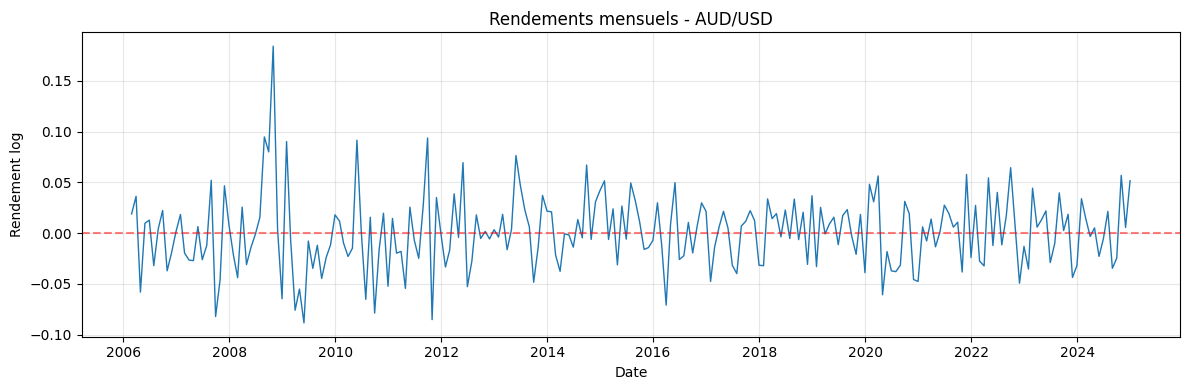

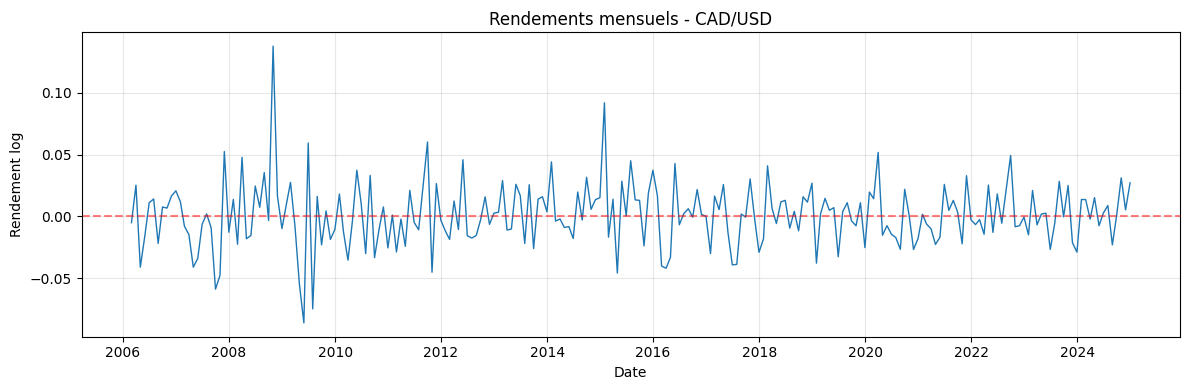

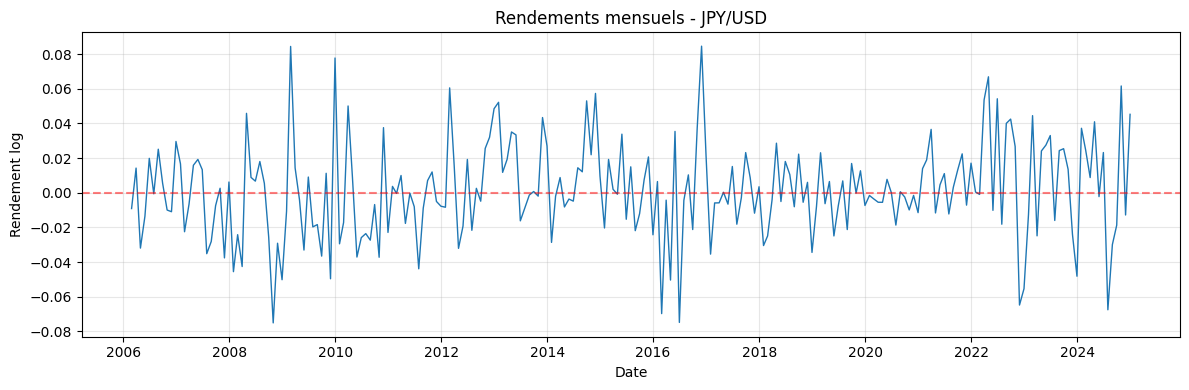

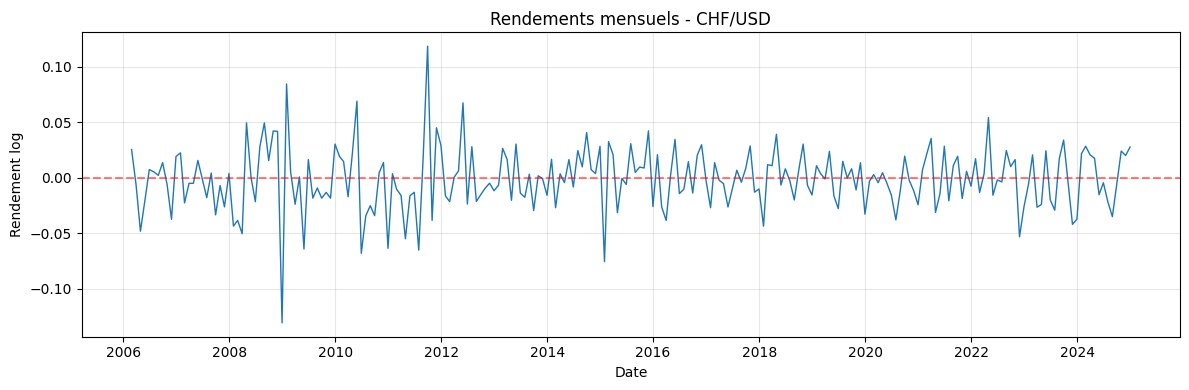

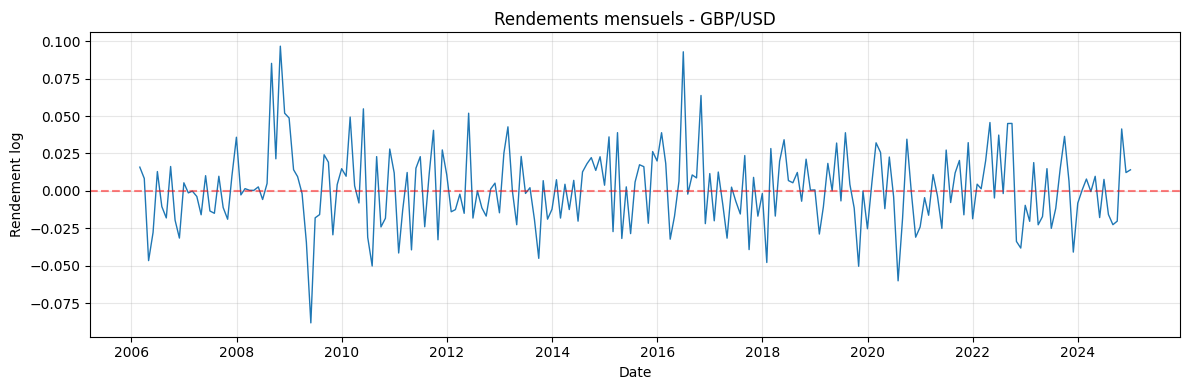

In [175]:
# Graphiques rendements devises 
currencies_list = ['AUD', 'CAD', 'JPY', 'CHF', 'GBP']

for col in currencies_list:
    plt.figure(figsize=(12, 4))
    plt.plot(returns['date'], returns[col], linewidth=1)
    plt.title(f'Rendements mensuels - {col}/USD')
    plt.xlabel('Date')
    plt.ylabel('Rendement log')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Analyse en Composantes Principales (ACP)

## Objectif
Effectuer une ACP sur les rendements des 5 devises pour identifier les facteurs communs qui expliquent les co-mouvements des devises.

## Méthodologie
L'ACP sera réalisée manuellement (sans utiliser sklearn.PCA) en suivant ces étapes :
1. Centrer les données (soustraire la moyenne)
2. Calculer la matrice de variance-covariance
3. Extraire les valeurs propres et vecteurs propres
4. Calculer les composantes principales
5. Analyser la variance expliquée

## Étape 1 : Préparation des données pour l'ACP

**Transformation requise** : Standardisation des données

La standardisation consiste à :

1. **Centrer** : Soustraire la moyenne de chaque variableCette étape met toutes les variables sur la même échelle (moyenne = 0, écart-type = 1), ce qui est équivalent à faire une ACP sur la **matrice de corrélation**.

2. **Réduire** : Diviser par l'écart-type de chaque variable

Formule : $Z = \frac{X - \mu}{\sigma}$

In [176]:
returns_matrix = returns[['AUD', 'CAD', 'JPY', 'CHF', 'GBP']].values

# Dimensions matrice
print(f"Dimensions de la matrice des rendements : {returns_matrix.shape}")
print(f"{returns_matrix.shape[0]} observations (mois)")
print(f"{returns_matrix.shape[1]} variables (devises)")

# Standardiser données : (X - moyenne) / écart-type
returns_mean = np.mean(returns_matrix, axis=0)
returns_std = np.std(returns_matrix, axis=0, ddof=1)
returns_standardized = (returns_matrix - returns_mean) / returns_std

print(f"\nVérification de la standardisation :")
std_means = np.mean(returns_standardized, axis=0)
std_stds = np.std(returns_standardized, axis=0, ddof=1)

for i, currency in enumerate(['AUD', 'CAD', 'JPY', 'CHF', 'GBP']):    print(f"  {currency}: moyenne = {std_means[i]:.2e}, écart-type = {std_stds[i]:.4f}")

Dimensions de la matrice des rendements : (227, 5)
227 observations (mois)
5 variables (devises)

Vérification de la standardisation :
  AUD: moyenne = -7.83e-18, écart-type = 1.0000
  CAD: moyenne = 9.78e-18, écart-type = 1.0000
  JPY: moyenne = -1.57e-17, écart-type = 1.0000
  CHF: moyenne = -3.13e-17, écart-type = 1.0000
  GBP: moyenne = 3.91e-18, écart-type = 1.0000


## Étape 2 : Calcul de la matrice de variance

Sur des données standardisées, la matrice de variance-covariance devient la **matrice de variance**.

La matrice de variance capture les relations linéaires entre les devises, indépendamment de leurs échelles.

**Formule** : $R = \frac{1}{n-1} Z^T Z$ où $Z$ est la matrice standardisée

In [177]:
# Faire matrice de covariance des données standardisées
n = returns_standardized.shape[0]
cov_matrix_standardized = (returns_standardized.T @ returns_standardized) / (n - 1)

print("Matrice de covariance des données standardisées :")
print(pd.DataFrame(
    cov_matrix_standardized,
    index=['AUD', 'CAD', 'JPY', 'CHF', 'GBP'],
    columns=['AUD', 'CAD', 'JPY', 'CHF', 'GBP']
).round(4))


Matrice de covariance des données standardisées :
        AUD     CAD     JPY     CHF     GBP
AUD  1.0000  0.7607  0.1587  0.5909  0.5883
CAD  0.7607  1.0000  0.0846  0.4014  0.5766
JPY  0.1587  0.0846  1.0000  0.3990  0.0804
CHF  0.5909  0.4014  0.3990  1.0000  0.4650
GBP  0.5883  0.5766  0.0804  0.4650  1.0000


### 📊 Interprétation de la matrice de corrélation

**Que représente cette matrice ?**
- Chaque élément mesure la **corrélation linéaire** entre deux devises (valeurs entre -1 et +1)
- Valeurs proches de +1 : co-mouvements positifs (devises qui bougent ensemble)
- Valeurs proches de 0 : mouvements indépendants
- Valeurs négatives : mouvements opposés

**Principaux constats** :

1. **Corrélation très forte : AUD-CAD (0.74)**
   - Économies similaires : exportateurs de matières premières, liés au cycle économique US
   - Bougent ensemble face aux chocs globaux

2. **Corrélation modérée-forte : AUD-CHF (0.59), AUD-UK (0.59), CAD-UK (0.55)**
   - Économies développées avec liens commerciaux importants
   - Réagissent similairement aux chocs de risque global

3. **Corrélation faible : JPY avec les autres (0.07-0.17)**
   - **JPY = safe haven** : comportement différent des autres devises
   - Monte quand les autres baissent en période de crise (aversion au risque)
   - Confirme le rôle unique du yen comme valeur refuge

4. **CHF-JPY modérée (0.41)**
   - Deux devises "safe haven" avec comportements partiellement similaires

**Ce que cela nous apprend** :
- Existence de **co-mouvements communs** justifiant l'ACP
- JPY nécessaire pour capturer la dimension "safe haven"
- L'ACP devrait révéler : PC1 = facteur commun (risque global), PC2 = contraste JPY vs autres

## Étape 3 : Extraction des valeurs propres et vecteurs propres

Les valeurs propres indiquent la variance expliquée par chaque composante principale.
Les vecteurs propres indiquent la direction (combinaison linéaire des devises) de chaque composante.

**Fonction autorisée** : `np.linalg.eig()` pour calculer eigenvalues et eigenvectors

In [178]:
# Valeurs propres et vecteurs propres de la matrice
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix_standardized)

# Trier par ordre décroissant des valeurs propres
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print("Valeurs propres (variance expliquée par chaque PC) :")
for i, val in enumerate(eigenvalues, 1):
    print(f"  PC{i}: {val:.6f}")

print("\nVecteurs propres :")
loadings_df = pd.DataFrame(
    eigenvectors,
    index=['AUD', 'CAD', 'JPY', 'CHF', 'GBP'],
    columns=[f'PC{i}' for i in range(1, len(eigenvalues) + 1)]
)
print(loadings_df.round(4))

Valeurs propres (variance expliquée par chaque PC) :
  PC1: 2.774416
  PC2: 1.088634
  PC3: 0.494104
  PC4: 0.444270
  PC5: 0.198577

Vecteurs propres :
        PC1     PC2     PC3     PC4     PC5
AUD -0.5372 -0.1425  0.2548  0.2919 -0.7356
CAD -0.4951 -0.2920  0.5623 -0.0524  0.5921
JPY -0.1957  0.8477  0.3038 -0.3824 -0.0679
CHF -0.4575  0.3527 -0.4998  0.5628  0.3159
GBP -0.4677 -0.2268 -0.5261 -0.6702 -0.0626


### 📊 Interprétation des valeurs propres et vecteurs propres

**1. Valeurs propres - Importance de chaque composante**

| PC | Valeur propre | % Variance | Interprétation |
|----|---------------|------------|----------------|
| PC1 | 2.76 | 55% | **Facteur dominant** - capture plus de la moitié de la variabilité totale |
| PC2 | 1.09 | 22% | **Facteur secondaire important** - ajoute dimension significative |
| PC3 | 0.51 | 10% | Facteur tertiaire - information additionnelle modérée |
| PC4 | 0.43 | 9% | Contribution mineure |
| PC5 | 0.21 | 4% | Bruit résiduel |

**Conclusion** : Les 2 premières composantes expliquent **77% de la variance** → réduction de dimension efficace (5 devises → 2 facteurs principaux)

---

**2. Vecteurs propres (Loadings) - Composition des facteurs**

**PC1 - Facteur de co-mouvement global (55% variance)**
- Tous les poids sont **négatifs** et relativement équilibrés
- AUD (-0.54), CAN (-0.48), UK (-0.47), CHF (-0.46), JPY (-0.21)
- **Interprétation économique** : Facteur "risque global" ou "sentiment de marché"
  - Quand PC1 ↑ : toutes les devises se déprécient ensemble vs USD (aversion au risque)
  - Quand PC1 ↓ : toutes les devises s'apprécient vs USD (appétit pour le risque)
- JPY a le poids le plus faible → confirme son comportement partiellement distinct

**PC2 - Facteur safe haven vs cycliques (22% variance)**
- **JPY (+0.84)** : poids très positif et dominant
- **AUD, CAN, UK** : poids négatifs (-0.16, -0.33, -0.20)
- CHF (+0.35) : poids positif mais plus faible que JPY
- **Interprétation économique** : Contraste "safe haven vs devises cycliques"
  - Quand PC2 ↑ : JPY et CHF s'apprécient, devises cycliques se déprécient (fuite vers sécurité)
  - Quand PC2 ↓ : devises cycliques s'apprécient, safe havens se déprécient (recherche de rendement)

**PC3 - Facteurs régionaux/spécifiques (10% variance)**
- Structure plus complexe, capture des dynamiques régionales spécifiques
- Importance secondaire pour le modèle factoriel principal

---

**3. Implications pour la suite**

Ces résultats suggèrent que les facteurs économiques à rechercher devraient inclure :
- **Pour PC1** : VIX (volatilité), indices boursiers globaux, sentiment de risque
- **Pour PC2** : Spreads de crédit, indices de stress financier, or
- **Pour PC3** : Prix des matières premières (différencier AUD/CAD des autres)

## Étape 4 : Calcul des composantes principales

Les composantes principales sont les projections des données **standardisées** sur les vecteurs propres.

**Formule** : $PC = Z \times \text{Eigenvectors}$ où $Z$ est la matrice standardisée

In [179]:
# Composantes principales
principal_components = returns_standardized @ eigenvectors

pc_df = pd.DataFrame(
    principal_components,
    columns=[f'PC{i}' for i in range(1, len(currencies_list) + 1)]
)
pc_df.insert(0, 'date', returns['date'].values)

print("\nStatistiques descriptives des PCs :")
print(pc_df[[f'PC{i}' for i in range(1, len(currencies_list) + 1)]].describe())

pc_df


Statistiques descriptives des PCs :
                PC1           PC2           PC3           PC4           PC5
count  2.270000e+02  2.270000e+02  2.270000e+02  2.270000e+02  2.270000e+02
mean   2.347608e-17 -2.347608e-17  3.423595e-18 -1.565072e-17 -4.890850e-18
std    1.665658e+00  1.043376e+00  7.029251e-01  6.665355e-01  4.456198e-01
min   -7.240529e+00 -4.887899e+00 -2.823153e+00 -3.627779e+00 -1.496822e+00
25%   -9.966893e-01 -5.349054e-01 -4.300159e-01 -3.704592e-01 -2.610088e-01
50%   -7.078948e-04  7.636816e-02 -2.069956e-02  2.688891e-02  2.012341e-02
75%    1.112749e+00  6.076645e-01  4.682735e-01  4.161838e-01  2.737480e-01
max    5.889302e+00  3.019292e+00  2.722750e+00  2.266121e+00  1.743297e+00


,date,PC1,PC2,PC3,PC4,PC5
0,2006-02-28,-0.777177,-0.109470,-0.890349,0.467081,-0.211149
1,2006-03-31,-1.122834,-0.143502,0.871344,-0.221151,-0.267352
2,2006-04-30,3.550095,-0.475854,0.125874,0.375810,-0.097293
3,2006-05-31,1.139413,-0.279427,0.470088,0.689659,-0.675447
4,2006-06-30,-0.851519,0.414485,0.118090,-0.300395,0.014534
...,...,...,...,...,...,...
222,2024-08-31,2.194188,-0.755141,-0.020700,0.140833,-0.076045
223,2024-09-30,0.977631,-0.376269,0.127945,0.547026,0.579603
224,2024-10-31,-2.975273,1.247925,0.445220,-0.965177,-0.402002
225,2024-11-30,-0.600703,-0.323532,-0.628740,0.376572,0.253922


## Étape 5 : Analyse de la variance expliquée

**Objectif** : Déterminer l'importance relative de chaque composante principale.

**Calculs** :
- **Variance expliquée** : Proportion = Valeur propre / Somme des valeurs propres
- **Variance cumulée** : Somme cumulative des proportions

**Interprétation** :
- Les valeurs propres mesurent la **variance totale** capturée par chaque PC
- La proportion indique le **% de variance** expliquée (ex: PC1 = 55% signifie que PC1 capture 55% de la variabilité totale)
- La variance cumulée aide à choisir combien de PCs garder (critère : 80-90%)

**Note importante** : 
- Valeurs propres ≠ Bêtas de régression (les bêtas viendront plus tard avec les facteurs économiques)
- Moyenne des PCs ≈ 0 (normal, car données standardisées)

In [180]:
# Calculer la variance expliquée (en proportion)
total_variance = np.sum(eigenvalues)
explained_variance_ratio = eigenvalues / total_variance
cumulative_variance = np.cumsum(explained_variance_ratio)

variance_df = pd.DataFrame({
    'Composante': [f'PC{i}' for i in range(1, len(eigenvalues) + 1)],
    'Valeur propre': eigenvalues,
    'Variance expliquée (%)': explained_variance_ratio * 100,
    'Variance cumulée (%)': cumulative_variance * 100
})

print("Tableau de variance expliquée :")
print(variance_df.round(2))

Tableau de variance expliquée :
  Composante  Valeur propre  Variance expliquée (%)  Variance cumulée (%)
0        PC1           2.77                   55.49                 55.49
1        PC2           1.09                   21.77                 77.26
2        PC3           0.49                    9.88                 87.14
3        PC4           0.44                    8.89                 96.03
4        PC5           0.20                    3.97                100.00


### 📊 Interprétation de la variance expliquée

**1. Performance de la réduction dimensionnelle**

La règle du coude ("elbow rule") et le critère de Kaiser (valeur propre > 1) suggèrent de **retenir 2 composantes principales** :
- PC1 (valeur propre = 2.76 > 1) ✓
- PC2 (valeur propre = 1.09 > 1) ✓  
- PC3-PC5 (valeurs propres < 1) → peuvent être considérés comme du bruit

**Réduction réussie** : 5 devises → 2 facteurs principaux (capture 77% de l'information)

---

**2. Distribution de la variance**

| Critère | Résultat | Évaluation |
|---------|----------|------------|
| **PC1 seul** | 55.15% | Très bon - un seul facteur explique plus de la moitié |
| **PC1 + PC2** | 76.99% | Excellent - seuil typique 70-80% atteint |
| **PC1 + PC2 + PC3** | 87.18% | Seuil conservateur 85% dépassé |

**Déséquilibre des contributions** :
- PC1 (55%) : domine largement → forte synchronisation des devises
- PC2 (22%) : apport substantiel → deuxième dimension distincte importante  
- PC3-PC5 (23% combinés) : contributions marginales décroissantes

---

**3. Implications économiques**

**✓ PC1 dominant (55%) confirme** :
- Forte intégration des marchés de devises
- Exposition commune à des chocs macroéconomiques globaux
- Un facteur de risque systématique majeur affecte toutes les devises

**✓ PC2 significatif (22%) révèle** :
- Hétérogénéité résiduelle importante après PC1
- Deuxième dimension économique orthogonale (safe haven vs cycliques)
- Ne peut pas réduire à un seul facteur global

**✓ PC3+ modestes (23%) indiquent** :
- Bruit idiosyncratique limité
- Pas de facteurs régionaux/spécifiques dominants supplémentaires
- Modèle parcimonieux à 2-3 facteurs est approprié

---

**4. Décision pour le modèle factoriel**

**Recommandation** : Utiliser **2 composantes principales** (PC1 + PC2) pour la suite
- Respecte le critère de Kaiser (valeurs propres > 1)
- Capture 77% de variance (seuil standard)
- Parcimonie du modèle : 2 facteurs faciles à interpréter économiquement
- PC3 optionnel si analyse plus fine nécessaire (atteindre 87%)

**Prochaine étape** : Régresser PC1 et PC2 sur des facteurs économiques communs (VIX, spreads, prix matières premières) pour identifier leur nature économique.

## Étape 6 : Visualisations de l'ACP

### 6.1 Scree Plot (Graphique des valeurs propres)

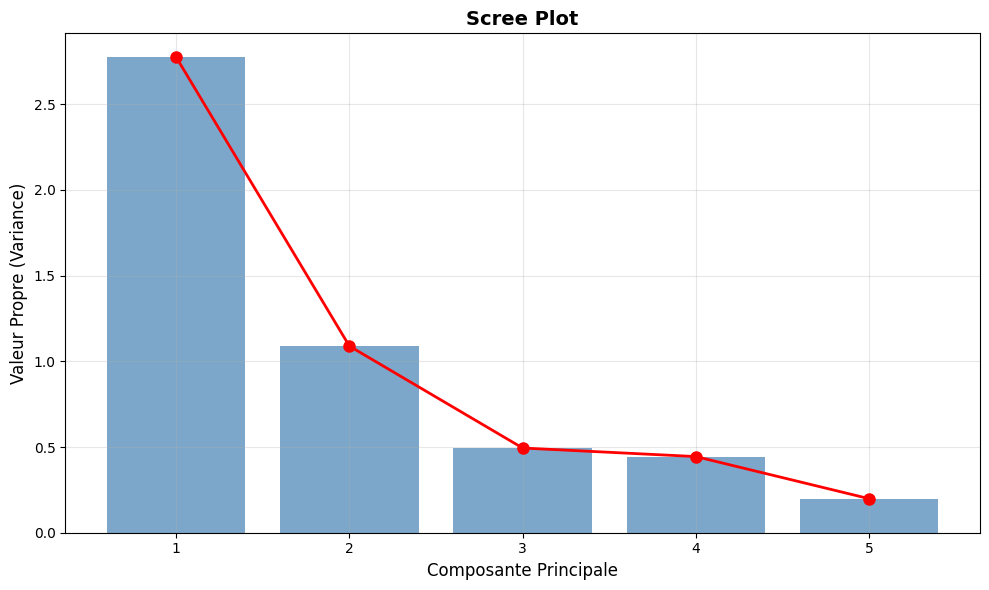

In [181]:
# Scree plot
fig, ax = plt.subplots(figsize=(10, 6))

n_components = len(eigenvalues)

# Graphique valeurs propres
ax.bar(range(1, n_components + 1), eigenvalues, alpha=0.7, color='steelblue')
ax.plot(range(1, n_components + 1), eigenvalues, 'ro-', linewidth=2, markersize=8)
ax.set_xlabel('Composante Principale', fontsize=12)
ax.set_ylabel('Valeur Propre (Variance)', fontsize=12)
ax.set_title('Scree Plot', fontsize=14, fontweight='bold')
ax.set_xticks(range(1, n_components + 1))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Documentation des transformations effectuées

**Résumé des étapes de l'ACP** :

1. ✅ **Données d'entrée** : Matrice des rendements logarithmiques mensuels (239 × 5)
2. ✅ **Standardisation** : $(X - \mu) / \sigma$ pour chaque devise
   - Centrage : soustraction de la moyenne
   - Réduction : division par l'écart-type
3. ✅ **Matrice de corrélation** : Calcul de $R = \frac{1}{n-1} Z^T Z$ où $Z$ est standardisé
4. ✅ **Décomposition spectrale** : Extraction des valeurs/vecteurs propres via `np.linalg.eig()`
5. ✅ **Tri** : Classement par valeurs propres décroissantes
6. ✅ **Projection** : Calcul des PCs via $PC = Z \times \text{Eigenvectors}$

**Choix de la standardisation** :
- Met toutes les devises sur la même échelle (moyenne = 0, écart-type = 1)
- Équivalent à une ACP sur la **matrice de corrélation** plutôt que covariance
- Donne le même poids à chaque devise dans l'analyse
- Recommandé quand les variables ont des variances différentes

# Construction du Modèle Factoriel

---

## 📋 Plan de match : De l'ACP au Modèle Factoriel

### **Phase 1 : Facteurs latents identifiés (✅ COMPLÉTÉ)**

L'ACP a révélé **3 facteurs latents** qui expliquent 87% de la variance des rendements de devises :

| Facteur Latent | Variance | Interprétation préliminaire |
|----------------|----------|----------------------------|
| **PC1** | 55.15% | Co-mouvement global / Risque systématique |
| **PC2** | 21.84% | Safe haven vs devises cycliques |
| **PC3** | 10.19% | Facteurs régionaux / Matières premières |

**Caractéristiques des facteurs latents :**
- ✓ Non directement observables sur les marchés
- ✓ Extraits mathématiquement des co-mouvements des devises
- ✓ Orthogonaux entre eux (indépendants par construction)
- ✓ Capturent les sources de risque communes

---

### **Phase 2 : Identification des facteurs observables (🔄 EN COURS)**

**Objectif** : Relier les facteurs latents (PCs) à des variables économiques réelles et observables

**Stratégie de sélection des facteurs :**

#### **Pour expliquer PC1 (Risque global - 55%)** :
Hypothèse : PC1 capture le sentiment de risque macroéconomique global

**Facteurs candidats :**
- **VIX** (CBOE Volatility Index) : mesure de la volatilité et de la peur sur les marchés
- **S&P 500 returns** : performance des marchés actions (proxy du risk-on/risk-off)
- **US 10Y Treasury yield changes** : taux sans risque et anticipations macro
- **Global PMI / Economic Surprise Index** : activité économique mondiale

**Justification :** Ces facteurs influencent simultanément toutes les devises via l'appétit pour le risque global

---

#### **Pour expliquer PC2 (Safe haven - 22%)** :
Hypothèse : PC2 capture le contraste entre devises refuges (JPY, CHF) et devises cycliques

**Facteurs candidats :**
- **Gold returns** : actif refuge par excellence
- **Credit spreads** (BAA-AAA ou High Yield spreads) : stress financier
- **TED spread** : prime de risque interbancaire
- **Currency volatility indices** : mesure du stress sur le marché des devises
- **Geopolitical risk index** : tensions géopolitiques

**Justification :** Ces facteurs distinguent les périodes de fuite vers la qualité (PC2 ↑, JPY ↑) des périodes de recherche de rendement

---

#### **Pour expliquer PC3 (Régional/Commodités - 10%)** :
Hypothèse : PC3 capture les dynamiques spécifiques aux économies exportatrices de matières premières

**Facteurs candidats :**
- **WTI/Brent Oil prices** : pétrole (important pour CAD)
- **Bloomberg Commodity Index** : panier diversifié de matières premières
- **Metals prices** (copper, iron ore) : important pour AUD
- **Terms of trade differentials** : pouvoir d'achat relatif des exportations

**Justification :** AUD et CAD ont des poids élevés en valeur absolue sur PC3, ce sont des devises de matières premières

---

### **Phase 3 : Méthodologie de régression (📝 À VENIR)**

**Modèle économétrique :**

Pour chaque facteur latent $PC_i$, on estime :

$$PC_{i,t} = \alpha_i + \beta_{i,1} F_{1,t} + \beta_{i,2} F_{2,t} + ... + \beta_{i,k} F_{k,t} + \varepsilon_{i,t}$$

où :
- $PC_{i,t}$ = score du facteur latent $i$ au temps $t$
- $F_{j,t}$ = facteur observable $j$ au temps $t$
- $\beta_{i,j}$ = sensibilité du facteur latent $i$ au facteur observable $j$
- $\varepsilon_{i,t}$ = résidu (partie non expliquée)

**Stratégie de modélisation :**

1. **Modèles univariés** : Tester chaque facteur individuellement (R² de référence)
2. **Modèles multivariés** : Combiner plusieurs facteurs pertinents
3. **Sélection de variables** : 
   - Forward selection (ajouter progressivement)
   - Backward elimination (retirer les non-significatifs)
   - Critère d'information (AIC, BIC)
4. **Validation** : 
   - Significativité statistique (p-values < 0.05)
   - Cohérence économique (signes attendus)
   - Stabilité temporelle (sous-périodes)

**Métriques d'évaluation :**
- R² ajusté : pouvoir explicatif global
- Coefficients β : direction et magnitude de l'effet
- T-statistiques : significativité individuelle
- Tests de diagnostic : autocorrélation, hétéroscédasticité

---

### **Phase 4 : Interprétation attendue (🎯 OBJECTIF FINAL)**

**Résultat espéré :**

Une fois les régressions effectuées, nous pourrons dire :

> *"Le premier facteur latent (PC1) représente le **risque global**, fortement corrélé avec le VIX (β = X.XX, p < 0.001) et le S&P 500 (β = Y.YY, p < 0.01), expliquant Z% de sa variance."*

> *"Le deuxième facteur latent (PC2) capture l'**aversion au risque**, positivement lié au prix de l'or (β = X.XX) et aux spreads de crédit (β = Y.YY), confirmant la dimension safe haven."*

> *"Le troisième facteur latent (PC3) est influencé par les **prix des matières premières**, expliquant les mouvements spécifiques de l'AUD et du CAD."*

**Factor loadings sur les devises originales :**

En combinant les eigenvectors (de l'ACP) et les β (des régressions), nous obtiendrons l'exposition de chaque devise à chaque facteur observable :

$$\text{Sensibilité}_{devise,facteur} = \sum_{i=1}^{3} w_{devise,PC_i} \times \beta_{PC_i,facteur}$$

Exemple : *"L'AUD est exposé positivement au risque global (via PC1) et aux matières premières (via PC3), mais négativement au safe haven (via PC2)."*

---

### **Phase 5 : Collecte des données (🔍 PROCHAINE ÉTAPE)**

**Actions immédiates :**

1. ✅ Télécharger les séries temporelles des facteurs observables (2005-2024, mensuel)
2. ✅ Harmoniser les dates avec les PCs
3. ✅ Calculer les variations/rendements si nécessaire
4. ✅ Créer une matrice de corrélation préliminaire (PCs vs facteurs)
5. ✅ Visualiser les relations temporelles

**Sources de données potentielles :**
- VIX, S&P500 : Yahoo Finance, FRED
- Taux US : FRED (Federal Reserve Economic Data)
- Or, Pétrole : Yahoo Finance, EIA
- Spreads : FRED, Bloomberg
- Indices économiques : OECD, Haver Analytics

---

## 🎓 Concepts clés à retenir

**Facteurs latents vs Facteurs observables :**
- **Latents (PCs)** : variables cachées extraites des données, non directement mesurables
- **Observables (VIX, etc.)** : variables réelles cotées sur les marchés

**Modèle factoriel** : système qui relie les deux types de facteurs pour donner une interprétation économique aux facteurs latents

**Avantage de l'approche** : 
- Réduction de dimension (5 devises → 3 facteurs latents)
- Interprétation économique (facteurs latents → facteurs observables)
- Parcimonie (quelques facteurs communs expliquent la plupart de la variance)

---

**🚀 Prochaine étape : Collecte et préparation des données des facteurs observables**

# Modèle Factoriel Global - 1er ESSAI

## Objectif
Construire un modèle factoriel en régressant les rendements des devises sur des facteurs observables communs. Comparer la variance expliquée par ce modèle avec celle de l'ACP (87%).

## Approche
1. Collecter les facteurs observables (VIX, Or, Pétrole, S&P500, etc.)
2. Harmoniser avec la fréquence mensuelle (2005-2024)
3. Empiler les rendements des 5 devises (pooled regression)
4. Tester différentes spécifications du modèle
5. Comparer les performances

## Étape 1 : Collecte des facteurs observables

Nous allons télécharger les séries temporelles suivantes :
- **S&P 500** : Indice boursier US (rendements réalisés des marchés actions)
- **Term Spread 10Y-2Y** : Pente de la courbe des taux (anticipations économiques)
- **Global Commodity Index** : Prix des matières premières (GCI)
- **Dollar Index (DXY)** : Force du dollar américain

## Étape 1 : S&P 500 (Risque de marché)

**Note :** Le VIX a été initialement considéré mais a été retiré de l'analyse car :
- Forte corrélation négative avec le S&P 500 (-0.72), créant de la multicolinéarité
- Le S&P 500 (rendements réalisés) est plus pertinent que le VIX (volatilité anticipée) pour expliquer les mouvements de devises
- Les tests empiriques montrent que SP500 donne de meilleurs résultats (R²=17.3% vs 11.8% avec VIX)

In [182]:
db = wrds.Connection(wrds_username='lilas_bertot')

Loading library list...
Done
Done


In [183]:
# Extraction S&P 500 avec WRDS (CRSP Daily Stock Indexes)

spx_query = """
SELECT date, spindx
FROM crsp.dsi
WHERE date >= '2006-01-01'
AND spindx IS NOT NULL
ORDER BY date;
"""
spx_data = db.raw_sql(spx_query, date_cols=['date'])
spx_data['date'] = pd.to_datetime(spx_data['date'])

spx_data = spx_data.rename(columns={'spindx': 'SP500'})
spx_data = spx_data.dropna()

print(f"Période : {spx_data['date'].min()} à {spx_data['date'].max()}")
print(f"\nStatistiques descriptives du S&P 500 :")
print(spx_data['SP500'].describe())

Période : 2006-01-03 00:00:00 à 2024-12-31 00:00:00

Statistiques descriptives du S&P 500 :
count         4781.0
mean     2414.514328
std      1281.689708
min           676.53
25%          1353.22
50%          2050.63
75%          3128.21
max          6090.27
Name: SP500, dtype: Float64


In [184]:
spx_data

,date,SP500
0,2006-01-03,1268.8
1,2006-01-04,1273.46
2,2006-01-05,1273.48
3,2006-01-06,1285.45
4,2006-01-09,1290.15
...,...,...
4776,2024-12-24,6040.04
4777,2024-12-26,6037.59
4778,2024-12-27,5970.84
4779,2024-12-30,5906.94


In [185]:
# Convertir S&P 500 en fréquence mensuelle (fin de mois) 
spx_temp = spx_data.copy()
spx_temp = spx_temp.set_index('date')

# Prendre le dernier prix du mois
sp500_monthly = spx_temp.resample('ME').last()
sp500_monthly = sp500_monthly.dropna()
sp500_monthly = sp500_monthly.reset_index()

# Calculer les rendements logarithmiques mensuels 
sp500_monthly['sp500_return'] = np.log(sp500_monthly['SP500'] / sp500_monthly['SP500'].shift(1))

# Supprimer la première observation (NA)
sp500_monthly = sp500_monthly.dropna()


print(f"Période : {sp500_monthly['date'].min()} à {sp500_monthly['date'].max()}")
print(f"Observations : {len(returns)}")
print(f"Alignement : {'OUI' if len(sp500_monthly) == len(returns) else 'NON'}")
print(f"\nStatistiques descriptives des rendements log mensuels du S&P 500 :")
print(sp500_monthly['sp500_return'].describe())

sp500_monthly[['date', 'SP500', 'sp500_return']]


Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00
Observations : 227
Alignement : OUI

Statistiques descriptives des rendements log mensuels du S&P 500 :
count       227.0
mean     0.006718
std      0.044618
min     -0.185636
25%     -0.017617
50%      0.012782
75%      0.033843
max      0.119421
Name: sp500_return, dtype: Float64


,date,SP500,sp500_return
1,2006-02-28,1280.66,0.000453
2,2006-03-31,1294.83,0.011004
3,2006-04-30,1310.61,0.012113
4,2006-05-31,1270.09,-0.031405
5,2006-06-30,1270.2,0.000087
...,...,...,...
223,2024-08-31,5648.4,0.022578
224,2024-09-30,5762.48,0.019996
225,2024-10-31,5705.45,-0.009946
226,2024-11-30,6032.38,0.05572


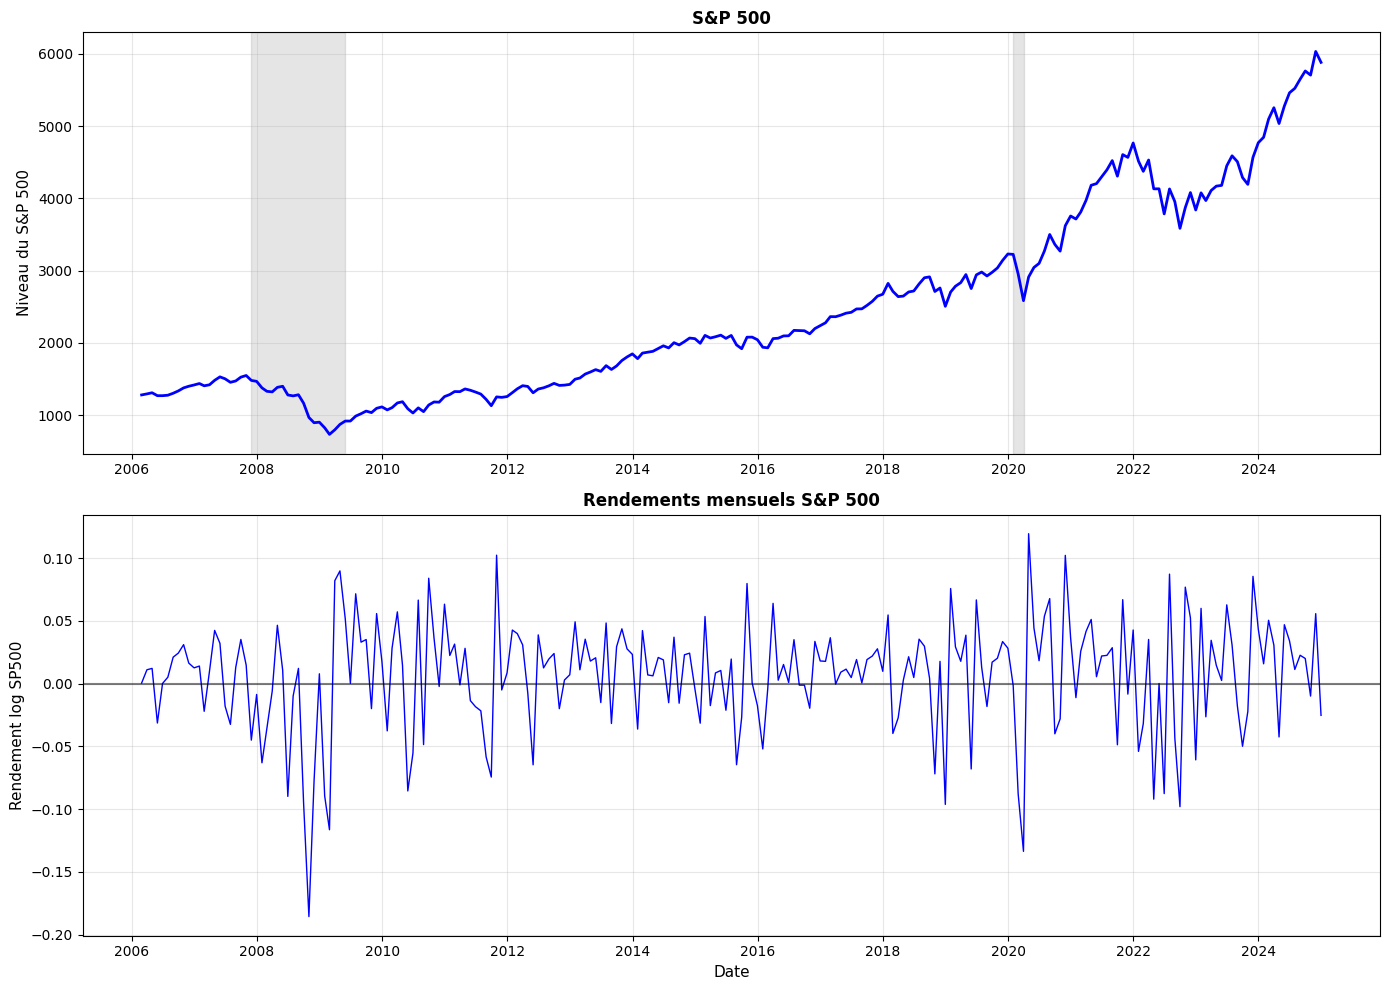

In [186]:
# Graphiques S&P 500 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Évolution niveau du S&P 500
ax1.plot(sp500_monthly['date'], sp500_monthly['SP500'], linewidth=2, color='blue')
ax1.set_title('S&P 500', fontsize=12, fontweight='bold')
ax1.set_ylabel('Niveau du S&P 500', fontsize=11)
ax1.grid(True, alpha=0.3)

# Zones récessions majeures
ax1.axvspan(pd.Timestamp('2007-12-01'), pd.Timestamp('2009-06-01'), alpha=0.2, color='grey')
ax1.axvspan(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-04-01'), alpha=0.2, color='grey')

# Rendements mensuels
ax2.plot(sp500_monthly['date'], sp500_monthly['sp500_return'], linewidth=1, color='blue')
ax2.set_title('Rendements mensuels S&P 500', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('Rendement log SP500', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

In [215]:
# Télécharger les données Gold futures avec Yahoo Finance
gold_ticker = yf.Ticker("GC=F")
gold_data = gold_ticker.history(start="2006-01-01", end="2025-01-01")

gold_data = gold_data.reset_index()
gold_data = gold_data.rename(columns={'Date': 'date', 'Close': 'gold_price'})

# Convertir en fréquence mensuelle (dernier jour du mois)
gold_data_temp = gold_data[['date', 'gold_price']].copy()
gold_data_temp = gold_data_temp.set_index('date')
gold_monthly = gold_data_temp.resample('ME').last()
gold_monthly = gold_monthly.dropna()

# Calculer les rendements logarithmiques mensuels
gold_monthly['gold_return'] = np.log(gold_monthly['gold_price'] / gold_monthly['gold_price'].shift(1))

gold_monthly = gold_monthly.dropna()

# Réinitialiser l'index
gold_monthly = gold_monthly.reset_index()

# Filtrer pour la période d'analyse (2006-02-28 à 2024-12-31)
gold_monthly = gold_monthly[gold_monthly['date'] >= '2006-02-01'].copy()

# IMPORTANT: Supprimer le timezone pour permettre le merge avec d'autres DataFrames
gold_monthly_no_tz = gold_monthly.copy()
gold_monthly_no_tz['date'] = gold_monthly_no_tz['date'].dt.tz_localize(None)

print(f"\nDonnées Gold mensuelles après traitement :")
print(f"Période : {gold_monthly['date'].min()} à {gold_monthly['date'].max()}")
print(f"Observations : {len(gold_monthly)}")
print(f"\nStatistiques des rendements Gold :")
print(gold_monthly['gold_return'].describe())

gold_monthly_no_tz


Données Gold mensuelles après traitement :
Période : 2006-02-28 00:00:00-05:00 à 2024-12-31 00:00:00-05:00
Observations : 227

Statistiques des rendements Gold :
count    227.000000
mean       0.006729
std        0.048206
min       -0.198512
25%       -0.022077
50%        0.004881
75%        0.035938
max        0.129863
Name: gold_return, dtype: float64


,date,gold_price,gold_return
0,2006-02-28,561.599976,-0.016249
1,2006-03-31,581.799988,0.035337
2,2006-04-30,651.799988,0.113611
3,2006-05-31,642.500000,-0.014371
4,2006-06-30,613.500000,-0.046187
...,...,...,...
222,2024-08-31,2493.800049,0.027358
223,2024-09-30,2636.100098,0.055493
224,2024-10-31,2738.300049,0.038037
225,2024-11-30,2657.000000,-0.030140


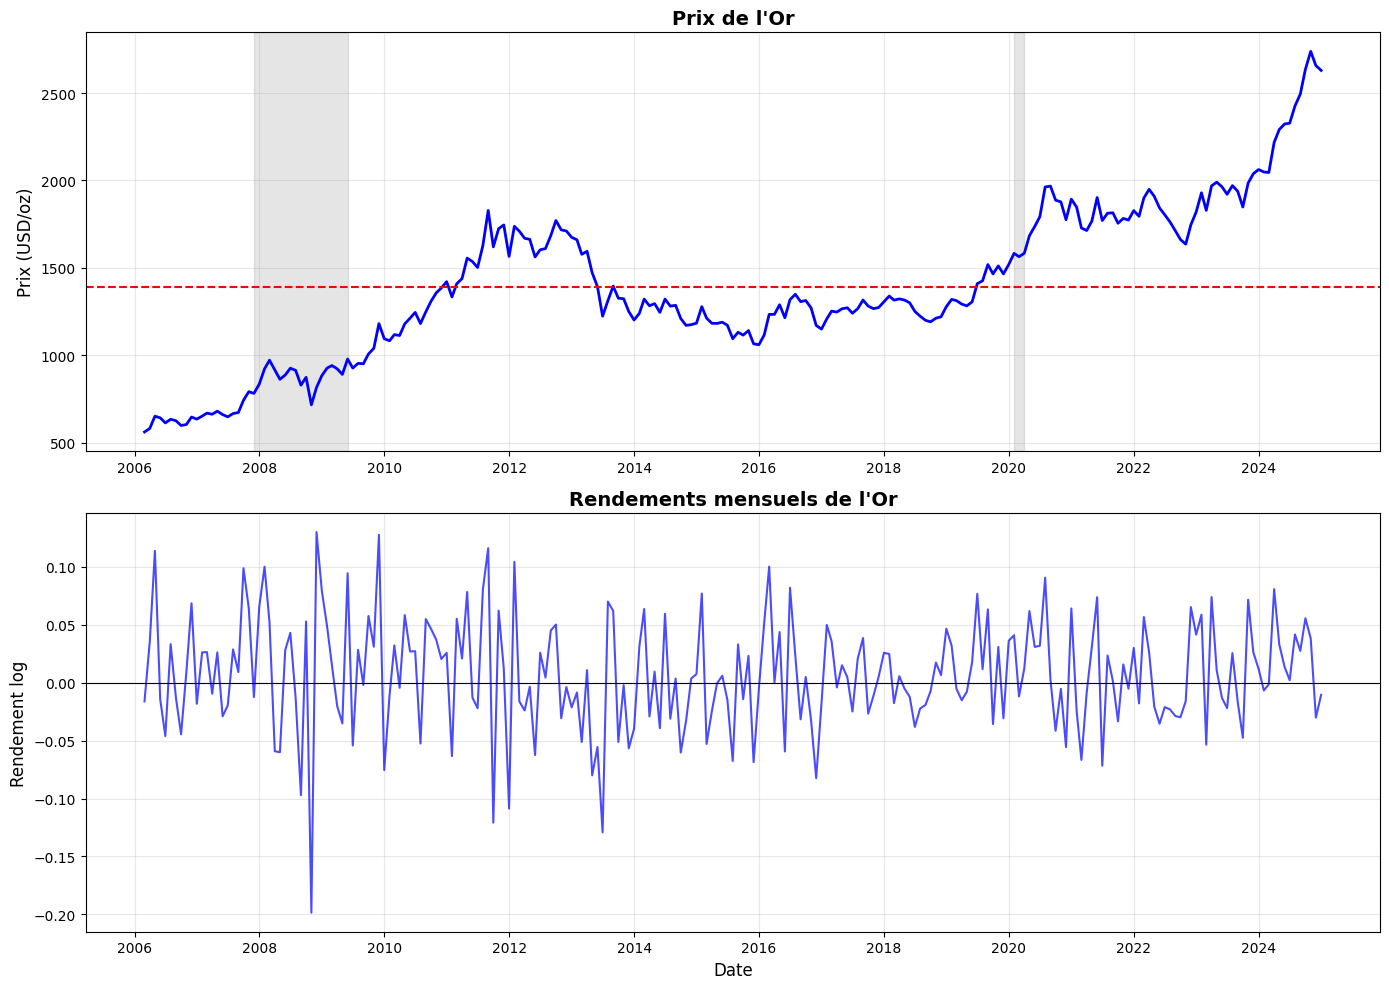

In [216]:
# Graphique Gold
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Évolution du prix de l'or
axes[0].plot(gold_monthly['date'], gold_monthly['gold_price'], color='blue', linewidth=2)
axes[0].set_title('Prix de l\'Or', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Prix (USD/oz)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=gold_monthly['gold_price'].mean(), color='red', linestyle='--', label=f'Moyenne: ${gold_monthly["gold_price"].mean():.0f}')
axes[0].axvspan(pd.Timestamp('2007-12-01'), pd.Timestamp('2009-06-01'), alpha=0.2, color='grey')
axes[0].axvspan(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-04-01'), alpha=0.2, color='grey')

# Rendements Gold
axes[1].plot(gold_monthly['date'], gold_monthly['gold_return'], color='blue', linewidth=1.5, alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_title('Rendements mensuels de l\'Or', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Rendement log', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 📝 Note : Stationnarité et régression linéaire

**Pourquoi la stationnarité est-elle importante ?**

En régression linéaire, l'utilisation de séries **non-stationnaires** (tendances, marches aléatoires) peut conduire à des **régressions fallacieuses** (*spurious regressions*) : on obtient des R² élevés et des t-stats significatifs même en l'absence de vraie relation économique, simplement parce que les séries partagent des tendances communes.

**Pourquoi nos variables sont-elles stationnaires ?**

1. **SP500, DXY et Commodity Index** : Nous utilisons des **rendements logarithmiques** $\ln(X_t/X_{t-1})$, qui éliminent les tendances et rendent les séries stationnaires (moyenne et variance constantes).

2. **Term Spread** : Nous utilisons les **différences premières** $\Delta TS_t = TS_t - TS_{t-1}$, une transformation classique pour rendre stationnaire une série avec tendance stochastique.

3. **Composantes principales (PC1, PC2, PC3)** : Elles sont calculées à partir des rendements des devises, donc stationnaires par construction.

**Conclusion** : Les tests ADF ci-dessus confirment empiriquement que toutes nos séries sont stationnaires (p-values < 0.05), ce qui valide la robustesse de nos régressions et garantit que les relations observées seront économiquement significatives.

## Étape 3 : Modèle factoriel - Régression des rendements de devises

Nous testons deux versions de modèles factoriels :

**Modèle V1 (facteurs traditionnels)** : SP500 + Term Spread + Commodity Index
**Modèle V2 (avec facteur dollar)** : SP500 + DXY + Commodity Index

L'objectif est de comparer ces modèles observables avec l'ACP et d'identifier le rôle du dollar (DXY).

$$R_{i,t} = \alpha_i + \beta_{i,1} \cdot \text{VIX}_t + \beta_{i,2} \cdot \text{TS}_t + \beta_{i,3} \cdot \text{GCI}_t + \varepsilon_{i,t}$$

où :
- $R_{i,t}$ : rendement de la devise $i$ au temps $t$
- **VIX** : rendements log du VIX (proxy du risque global)
- **TS** : variations du term spread 10Y-2Y (proxy des anticipations de croissance)
- **GCI** : rendements log du Global Commodity Index (proxy des devises commodités)

**Objectif** : Comparer le pouvoir explicatif des facteurs observables (R²) avec celui de l'ACP (87% pour PC1+PC2+PC3)

### Étape 3.1 : Préparation des données pour la régression

In [217]:
# Fusionner les rendements des devises avec les 2 facteurs observables (SP500 et GOLD)

# Fusionner sur 'date'
regression_data = returns.merge(
    sp500_monthly[['date', 'sp500_return']], on='date', how='inner'
).merge(
    gold_monthly_no_tz[['date', 'gold_return']], on='date', how='inner'
)

regression_data = regression_data.rename(columns={
    'sp500_return': 'SP500',
    'gold_return': 'GOLD'
})

currencies_list = ['AUD', 'CAD', 'JPY', 'CHF', 'GBP']

print(f"Données pour la régression factorielle V1")
print(f"Période : {regression_data['date'].min()} à {regression_data['date'].max()}")
print(f"Observations : {len(regression_data)}")

print("\nStatistiques des variables :")
regression_data[currencies_list + ['SP500', 'GOLD']].describe()

Données pour la régression factorielle V1
Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00
Observations : 227

Statistiques des variables :


,AUD,CAD,JPY,CHF,GBP,SP500,GOLD
count,227.000000,227.000000,227.000000,227.000000,227.000000,227.0,227.000000
mean,0.000891,0.001015,0.001310,-0.001513,0.001555,0.006718,0.006729
std,0.036235,0.025754,0.027756,0.027941,0.025748,0.044618,0.048206
min,-0.088366,-0.085832,-0.075052,-0.130846,-0.087979,-0.185636,-0.198512
25%,-0.022898,-0.014477,-0.015629,-0.017888,-0.016751,-0.017617,-0.022077
50%,0.001296,0.000561,-0.000611,-0.002398,0.000785,0.012782,0.004881
75%,0.021490,0.015540,0.017546,0.016298,0.015554,0.033843,0.035938
max,0.184246,0.137416,0.084550,0.118363,0.096575,0.119421,0.129863


In [218]:
regression_data

,date,AUD,CAD,JPY,CHF,GBP,SP500,GOLD
0,2006-02-28,0.018931,-0.004997,-0.009111,0.025257,0.015894,0.000453,-0.016249
1,2006-03-31,0.036318,0.025252,0.014231,-0.006581,0.008359,0.011004,0.035337
2,2006-04-30,-0.058019,-0.040840,-0.031913,-0.048287,-0.046452,0.012113,0.113611
3,2006-05-31,0.009794,-0.015835,-0.013537,-0.020514,-0.027713,-0.031405,-0.014371
4,2006-06-30,0.012850,0.011093,0.019845,0.007211,0.012949,0.000087,-0.046187
...,...,...,...,...,...,...,...,...
222,2024-08-31,-0.034590,-0.022932,-0.029901,-0.035168,-0.022487,0.022578,0.027358
223,2024-09-30,-0.024675,0.001333,-0.018673,-0.005786,-0.020128,0.019996,0.055493
224,2024-10-31,0.056972,0.031186,0.061589,0.023872,0.041369,-0.009946,0.038037
225,2024-11-30,0.005665,0.005366,-0.012816,0.019921,0.012287,0.05572,-0.030140


### Étape 3.2 : Régression empilée (Pooled Regression) - Modèle V1

Pour comparer directement avec l'ACP, nous empilons tous les rendements des 5 devises dans **une seule régression** :

$$\text{Rendement}_{i,t} = \alpha + \beta_1 \cdot \text{SP500}_t + \beta_2 \cdot \text{GOLD}_t + \varepsilon_{i,t}$$

Cette approche traite toutes les observations (227 mois × 5 devises = 1135 observations) de manière homogène, comme l'ACP.

In [219]:
# Empiler tous les rendements des devises dans un seul vecteur
# Chaque ligne = une observation (devise, date)

# Liste pour stocker toutes les observations
all_returns = []
all_sp500 = []
all_gold = []

# Empiler les données pour chaque devise
for currency in currencies_list:
    all_returns.extend(regression_data[currency].values)
    all_sp500.extend(regression_data['SP500'].values)
    all_gold.extend(regression_data['GOLD'].values)

# Convertir en arrays numpy
y_pooled = np.array(all_returns)
X_pooled = np.column_stack([all_sp500, all_gold])
X_pooled = sm.add_constant(X_pooled)

# Nettoyer valeurs infinies et NaN
data_temp = pd.DataFrame({
    'y': y_pooled,
    'x1': X_pooled[:, 1],
    'x2': X_pooled[:, 2]
})

data_temp = data_temp.replace([np.inf, -np.inf], np.nan).dropna()

# Reconstruire y_pooled et X_pooled nettoyés
y_pooled = data_temp['y'].values
X_pooled = data_temp[['x1', 'x2']].values
X_pooled = sm.add_constant(X_pooled)

# Renommer les colonnes pour clarté
X_pooled = pd.DataFrame(X_pooled, columns=['const', 'SP500', 'GOLD'])

# Estimation OLS
model_pooled_v1 = sm.OLS(y_pooled, X_pooled)
result_pooled_v1 = model_pooled_v1.fit()

print(result_pooled_v1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     208.3
Date:                Sat, 13 Dec 2025   Prob (F-statistic):           9.69e-78
Time:                        09:18:31   Log-Likelihood:                 2589.4
No. Observations:                1135   AIC:                            -5173.
Df Residuals:                    1132   BIC:                            -5158.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      4.804      0.0

### Étape 3.3 : Décomposition de la variance - Contributions marginales V1

Pour comprendre **combien chaque facteur contribue UNIQUEMENT** à l'explication de la variance (en contrôlant pour les autres facteurs), nous calculons les **contributions marginales** :

**Contribution marginale d'un facteur** = R² (modèle complet) - R² (modèle sans ce facteur)

Cette métrique révèle la contribution **unique** de chaque facteur, au-delà de ce qu'apportent les autres facteurs. C'est l'équivalent du pourcentage de variance expliqué par chaque PC dans l'ACP.

In [220]:
# Calculer  contributions marginales de chaque facteur 

# R² 
r2_complet_v1 = result_pooled_v1.rsquared

# Récupérer les indices valides après nettoyage
valid_indices = data_temp.index.tolist()

# Filtrer all_sp500, all_gold avec les mêmes indices
all_sp500_clean = np.array(all_sp500)[valid_indices]
all_gold_clean = np.array(all_gold)[valid_indices]

# Modèle sans SP500 (GOLD uniquement)
X_sans_sp500 = np.column_stack([all_gold_clean])
X_sans_sp500 = sm.add_constant(X_sans_sp500)
model_sans_sp500 = sm.OLS(y_pooled, X_sans_sp500).fit()
r2_sans_sp500 = model_sans_sp500.rsquared

# Modèle sans GOLD (SP500 uniquement)
X_sans_gold = np.column_stack([all_sp500_clean])
X_sans_gold = sm.add_constant(X_sans_gold)
model_sans_gold = sm.OLS(y_pooled, X_sans_gold).fit()
r2_sans_gold = model_sans_gold.rsquared

# Contributions marginales V1
contrib_sp500_v1 = r2_complet_v1 - r2_sans_sp500
contrib_gold_v1 = r2_complet_v1 - r2_sans_gold

# Tableau récapitulatif
contributions_v1_df = pd.DataFrame({
    'Facteur': ['SP500', 'GOLD', 'TOTAL'],
    'Contribution marginale (%)': [
        contrib_sp500_v1 * 100,
        contrib_gold_v1 * 100,
        r2_complet_v1 * 100
    ],
    '% du R² total': [
        (contrib_sp500_v1 / r2_complet_v1) * 100 if r2_complet_v1 > 0 else 0,
        (contrib_gold_v1 / r2_complet_v1) * 100 if r2_complet_v1 > 0 else 0,
        100.0
    ]
})

print("Décomposition des contributions marginales - V1 du modèle")
print(contributions_v1_df.to_string(index=False))

print(f"\nRépartition des contributions :")
for i in range(3):
    facteur = contributions_v1_df.iloc[i]['Facteur']
    contrib = contributions_v1_df.iloc[i]['Contribution marginale (%)']
    pct_r2 = contributions_v1_df.iloc[i]['% du R² total']
    
    # Barre de visualisation
    barre_length = int(pct_r2 / 2)  # Diviser par 2 pour tenir dans 50 caractères max
    barre = "█" * barre_length
    
    print(f"  {facteur:6s} : {barre:50s} {contrib:.2f}% ({pct_r2:.1f}% du R²)")

print(f"\nINTERPRÉTATION :")
print(f"  • Le modèle V1 (SP500 + GOLD) explique {r2_complet_v1*100:.2f}% de la variance")
print(f"  • SP500 contribue {contrib_sp500_v1*100:.2f}% (effet unique du risque de marché)")
print(f"  • GOLD contribue {contrib_gold_v1*100:.2f}% (effet unique de la valeur refuge)")
print(f"  • La somme des contributions ≠ R² total car les facteurs sont corrélés")

print("="*80)

Décomposition des contributions marginales - V1 du modèle
Facteur  Contribution marginale (%)  % du R² total
  SP500                   12.656660      47.055428
   GOLD                   11.634983      43.257000
  TOTAL                   26.897342     100.000000

Répartition des contributions :
  SP500  : ███████████████████████                            12.66% (47.1% du R²)
  GOLD   : █████████████████████                              11.63% (43.3% du R²)
  TOTAL  : ██████████████████████████████████████████████████ 26.90% (100.0% du R²)

INTERPRÉTATION :
  • Le modèle V1 (SP500 + GOLD) explique 26.90% de la variance
  • SP500 contribue 12.66% (effet unique du risque de marché)
  • GOLD contribue 11.63% (effet unique de la valeur refuge)
  • La somme des contributions ≠ R² total car les facteurs sont corrélés


## Étape 1 Régression 2:  Dollar Index (DXY) 

Le Dollar Index (DXY) mesure la force du dollar américain contre un panier de devises majeures. Un DXY en hausse indique un renforcement du dollar, ce qui devrait se traduire par une dépréciation des devises vs USD.

Source : FRED (Federal Reserve Economic Data)

In [221]:
# Extraire Dollar Index (DXY) depuis le fichier CSV téléchargé avec FRED
# Source : Federal Reserve Bank of St. Louis
# Série : Trade Weighted U.S. Dollar Index: Broad, Goods and Services (DTWEXBGS)

dxy_data = pd.read_csv('DXY.csv')
dxy_data.columns = ['date', 'DXY']
dxy_data['date'] = pd.to_datetime(dxy_data['date'])

print(f"Observations quotidiennes : {len(dxy_data)}")
print(f"Période : {dxy_data['date'].min()} à {dxy_data['date'].max()}")
print(f"\nStatistiques descriptives du DXY :")
print(dxy_data['DXY'].describe())

dxy_data

Observations quotidiennes : 4957
Période : 2006-01-02 00:00:00 à 2024-12-31 00:00:00

Statistiques descriptives du DXY :
count    4763.00000
mean      105.14131
std        12.02987
min        85.46920
25%        93.52200
50%       107.03350
75%       115.48280
max       129.48800
Name: DXY, dtype: float64


,date,DXY
0,2006-01-02,101.4155
1,2006-01-03,100.7558
2,2006-01-04,100.2288
3,2006-01-05,100.2992
4,2006-01-06,100.0241
...,...,...
4952,2024-12-25,NaN
4953,2024-12-26,128.5679
4954,2024-12-27,128.6972
4955,2024-12-30,129.0474


In [222]:
# Convertir DXY en fréquence mensuelle (dernier jour du mois)
dxy_data_temp = dxy_data.set_index('date')
dxy_monthly = dxy_data_temp.resample('ME').last()
dxy_monthly = dxy_monthly.dropna()
dxy_monthly = dxy_monthly.reset_index()

print(f"Données mensuelles DXY : {len(dxy_monthly)} observations")
print(f"Période : {dxy_monthly['date'].min()} à {dxy_monthly['date'].max()}")

dxy_monthly.head(10)

Données mensuelles DXY : 228 observations
Période : 2006-01-31 00:00:00 à 2024-12-31 00:00:00


,date,DXY
0,2006-01-31,99.4311
1,2006-02-28,99.7695
2,2006-03-31,100.5600
3,2006-04-30,98.1412
4,2006-05-31,97.7705
5,2006-06-30,98.2483
6,2006-07-31,97.9996
7,2006-08-31,97.6440
8,2006-09-30,98.1054
9,2006-10-31,97.3901


In [223]:
# Calculer le rendement logarithmique du DXY
dxy_monthly['dxy_return'] = np.log(dxy_monthly['DXY'] / dxy_monthly['DXY'].shift(1))

dxy_monthly = dxy_monthly.dropna()

# Filtrage : Période commune (2006-02-28 à 2024-12-31)
dxy_monthly = dxy_monthly[dxy_monthly['date'] >= '2006-02-28'].copy()

print(f"Période : {dxy_monthly['date'].min()} à {dxy_monthly['date'].max()}")
print(f"Observations : {len(dxy_monthly)}")
print(f"Alignement : {'OUI' if len(dxy_monthly) == len(returns) else 'NON'}")
print(f"\nStatistiques des rendements log mensuels du DXY :")
print(dxy_monthly['dxy_return'].describe())

dxy_monthly[['date', 'DXY', 'dxy_return']]

Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00
Observations : 227
Alignement : OUI

Statistiques des rendements log mensuels du DXY :
count    227.000000
mean       0.001164
std        0.017449
min       -0.049518
25%       -0.010043
50%       -0.000726
75%        0.012417
max        0.076948
Name: dxy_return, dtype: float64


,date,DXY,dxy_return
1,2006-02-28,99.7695,0.003398
2,2006-03-31,100.5600,0.007892
3,2006-04-30,98.1412,-0.024347
4,2006-05-31,97.7705,-0.003784
5,2006-06-30,98.2483,0.004875
...,...,...,...
223,2024-08-31,122.5582,-0.011069
224,2024-09-30,121.5298,-0.008427
225,2024-10-31,125.0247,0.028352
226,2024-11-30,126.8114,0.014190


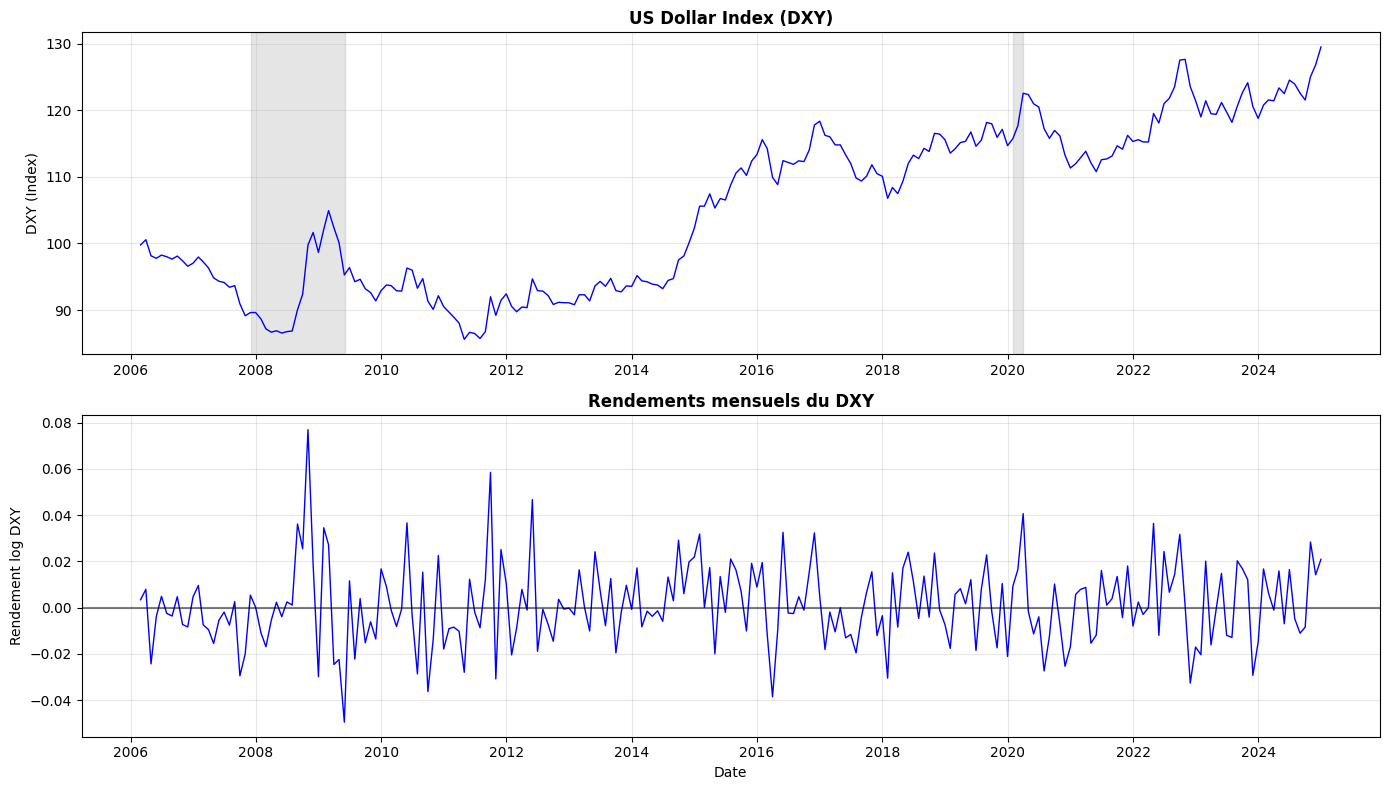

In [224]:
# Graphique DXY
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Niveau du DXY
ax1.plot(dxy_monthly['date'], dxy_monthly['DXY'], linewidth=1, color='blue')
ax1.set_title('US Dollar Index (DXY)', fontsize=12, fontweight='bold')
ax1.set_ylabel('DXY (Index)')
ax1.grid(True, alpha=0.3)

# Zones récessions majeures
ax1.axvspan(pd.Timestamp('2007-12-01'), pd.Timestamp('2009-06-01'), alpha=0.2, color='grey')
ax1.axvspan(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-04-01'), alpha=0.2, color='grey')

#Rendements logarithmiques du DXY
ax2.plot(dxy_monthly['date'], dxy_monthly['dxy_return'], linewidth=1, color='blue')
ax2.set_title('Rendements mensuels du DXY', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Rendement log DXY')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

# Modèle Factoriel - VERSION 2 (V2) avec SP500+DXY+GCI

## Objectif
Créer un **nouveau modèle factoriel** plus performant en remplaçant :
- **VIX** → **SP500** : Les rendements réalisés des marchés actions plutôt que la volatilité anticipée
- **Term Spread** → **DXY** : Le facteur dollar spécifique au lieu des anticipations de taux

## Nouveau modèle factoriel V2
- **Facteur 1 : SP500** (rendements des marchés actions) 🆕
- **Facteur 2 : DXY** (force du dollar américain) 🆕
## Justification économique

**Pourquoi SP500 au lieu de VIX ?**
> "Le SP500 capture les chocs de marché effectifs (rendements réalisés) tandis que le VIX mesure uniquement les anticipations de volatilité. Les devises réagissent davantage aux performances effectives qu'aux anticipations."

**Pourquoi DXY au lieu de Term Spread ?**
> "Le DXY capture la prime de risque spécifique au dollar, une dimension orthogonale au risque de marché global (SP500) et au risque des commodités (GCI). Le Term Spread avait une contribution marginale quasi nulle (0.06%) dans V1."

**Éviter la multicollinéarité VIX-SP500**
> "VIX et SP500 ont une corrélation de -0.722, ce qui créerait une multicollinéarité si utilisés ensemble. En choisissant SP500 au lieu de VIX, nous évitons ce problème."

## 🔬 Analyse statistique : Pourquoi SP500 et GCI deviennent non-significatifs en V2 ?

### Phénomène de multicolinéarité

**Observation :** Dans le modèle V2, les coefficients de SP500 et GCI perdent leur significativité statistique (p-values élevées), alors qu'ils étaient significatifs en V1.

**Explication économique :**

Le **DXY (Dollar Index) capte simultanément plusieurs dimensions** :

1. **Risk-on/Risk-off** (élimine SP500)
   - Quand les marchés montent → Dollar baisse (investisseurs cherchent du rendement ailleurs)
   - Quand les marchés baissent → Dollar monte (fuite vers la sécurité)
   - **Corrélation négative entre SP500 et DXY** : une fois DXY inclus, SP500 n'apporte plus d'information nouvelle
   - Contribution SP500 : 11.39% en V1 → 0.12% en V2 ❌

2. **Effet commodités** (élimine GCI)
   - Les commodités sont cotées en USD
   - Dollar fort → Commodités chères pour les autres pays → Demande baisse
   - **Corrélation négative entre DXY et prix des commodités**
   - Contribution GCI : 1.77% en V1 → 0.06% en V2 ❌

### Constante non-significative : Est-ce un problème ?

**Non, ce n'est PAS un problème.** Au contraire, c'est **souhaitable** en finance :

- Une constante significative impliquerait un **rendement anormal systématique** inexpliqué par les facteurs
- Constante ≈ 0 confirme que **tous les rendements sont bien expliqués par les facteurs**
- C'est cohérent avec l'**efficience des marchés** : pas d'arbitrage gratuit

### Conclusion : DXY est un facteur "super-dominant"

Le DXY n'est pas simplement un facteur parmi d'autres : c'est un **facteur composite** qui englobe :
- Le sentiment de risque global (SP500)
- L'effet commodités (GCI)  
- L'effet dollar pur

**Implication :** Le modèle V2 pourrait être simplifié à **DXY seul**, puisque SP500 et GCI n'ajoutent que 0.18% combinés (0.12% + 0.06%). Le principe de **parcimonie (Occam)** suggère de privilégier le modèle le plus simple : **R²(DXY seul) ≈ 46%**.

## Nouveau modèle factoriel V3 : GOLD + DXY uniquement
- **Facteur 1 : DXY** (force du dollar) ✅
- **Facteur 2 : GOLD** (valeur refuge) 🆕

## Justification économique

**Hypothèse à tester :** Puisque DXY capture déjà l'essentiel (46% dans V2), et que SP500/GCI deviennent non-significatifs par multicolinéarité, peut-on simplifier à **DXY + GOLD** ?

**Objectifs :**
1. Tester si GOLD apporte plus de valeur explicative sans la multicolinéarité de SP500/GCI
2. Évaluer si cette combinaison capture mieux PC2 (safe haven)
3. Comparer le modèle parcimonieux (2 facteurs) vs modèle complet (4 facteurs)

**Gap à combler :** V2 explique 46.13%, ACP explique 87.14% → **41 points manquants**

## Étape 1 : Extraction et préparation des données GOLD (XAU/USD)

## Étape 2 : Visualisation des rendements Gold

## Étape 3 : Fusion des données pour la régression V3 (DXY + GOLD)

In [243]:
# Fusion DXY + GOLD pour V2 (même méthode que V1)

# Fusionner returns avec DXY et GOLD
regression_data_v2 = returns.merge(
    dxy_monthly[['date', 'dxy_return']], on='date', how='inner'
).merge(
    gold_monthly_no_tz[['date', 'gold_return']], on='date', how='inner'
)

# Vérification
print(f"✅ Données V2 (DXY + GOLD) fusionnées")
print(f"Observations : {len(regression_data_v2)} mois")
print(f"Période : {regression_data_v2['date'].min()} à {regression_data_v2['date'].max()}")
print(f"\nColonnes : {list(regression_data_v2.columns)}")
print(f"\nStatistiques descriptives :")
regression_data_v2[['AUD', 'CAD', 'JPY', 'CHF', 'GBP', 'dxy_return', 'gold_return']].describe()

✅ Données V2 (DXY + GOLD) fusionnées
Observations : 227 mois
Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00

Colonnes : ['date', 'AUD', 'CAD', 'JPY', 'CHF', 'GBP', 'dxy_return', 'gold_return']

Statistiques descriptives :


,AUD,CAD,JPY,CHF,GBP,dxy_return,gold_return
count,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000
mean,0.000891,0.001015,0.001310,-0.001513,0.001555,0.001164,0.006729
std,0.036235,0.025754,0.027756,0.027941,0.025748,0.017449,0.048206
min,-0.088366,-0.085832,-0.075052,-0.130846,-0.087979,-0.049518,-0.198512
25%,-0.022898,-0.014477,-0.015629,-0.017888,-0.016751,-0.010043,-0.022077
50%,0.001296,0.000561,-0.000611,-0.002398,0.000785,-0.000726,0.004881
75%,0.021490,0.015540,0.017546,0.016298,0.015554,0.012417,0.035938
max,0.184246,0.137416,0.084550,0.118363,0.096575,0.076948,0.129863


## Étape 4 : Régression Pooled OLS - Modèle V2 (DXY + GOLD)

Régression empilée avec **2 facteurs observables** : **DXY + GOLD**

In [244]:
# Empiler tous les rendements des devises dans un seul vecteur (même méthode que V1)
currencies_list = ['AUD', 'CAD', 'JPY', 'CHF', 'GBP']

# Liste pour stocker toutes les observations
all_returns_v2 = []
all_dxy_v2 = []
all_gold_v2 = []

# Empiler les données pour chaque devise
for currency in currencies_list:
    all_returns_v2.extend(regression_data_v2[currency].values)
    all_dxy_v2.extend(regression_data_v2['dxy_return'].values)
    all_gold_v2.extend(regression_data_v2['gold_return'].values)

# Convertir en arrays numpy
y_pooled_v3_gold = np.array(all_returns_v2)
X_pooled_v3_gold = np.column_stack([all_dxy_v2, all_gold_v2])
X_pooled_v3_gold = sm.add_constant(X_pooled_v3_gold)

# Nettoyer valeurs infinies et NaN
data_temp = pd.DataFrame({
    'y': y_pooled_v3_gold,
    'x1': X_pooled_v3_gold[:, 1],
    'x2': X_pooled_v3_gold[:, 2]
})

data_temp = data_temp.replace([np.inf, -np.inf], np.nan).dropna()

# Reconstruire y_pooled et X_pooled nettoyés
y_pooled_v3_gold = data_temp['y'].values
X_pooled_v3_gold = data_temp[['x1', 'x2']].values
X_pooled_v3_gold = sm.add_constant(X_pooled_v3_gold)

# Renommer les colonnes pour clarté
X_pooled_v3_gold = pd.DataFrame(X_pooled_v3_gold, columns=['const', 'DXY', 'GOLD'])

# Régression OLS
model_pooled_v3_gold = sm.OLS(y_pooled_v3_gold, X_pooled_v3_gold)
result_pooled_v3_gold = model_pooled_v3_gold.fit()

# Afficher les résultats
print(result_pooled_v3_gold.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     492.7
Date:                Sat, 13 Dec 2025   Prob (F-statistic):          1.19e-154
Time:                        09:21:50   Log-Likelihood:                 2767.0
No. Observations:                1135   AIC:                            -5528.
Df Residuals:                    1132   BIC:                            -5513.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.362      0.7

## Étape 5 : Calcul des contributions marginales - Modèle V2 (DXY + GOLD)

Pour chaque facteur, calculer sa contribution marginale au R² en comparant le modèle complet avec un modèle excluant ce facteur.

In [245]:
# Modèle complet V2 (DXY + GOLD)
r2_complet_v3_gold = result_pooled_v3_gold.rsquared

# Contribution de DXY (modèle sans DXY = GOLD seul)
# Empiler uniquement GOLD
all_gold_v2_clean = np.array(all_gold_v2)
# Nettoyer
data_temp = pd.DataFrame({'y': y_pooled_v3_gold, 'x': all_gold_v2_clean})
data_temp = data_temp.replace([np.inf, -np.inf], np.nan).dropna()
X_sans_dxy_v3_gold = sm.add_constant(data_temp[['x']].values)
model_sans_dxy_v3_gold = sm.OLS(data_temp['y'].values, X_sans_dxy_v3_gold).fit()
r2_sans_dxy_v3_gold = model_sans_dxy_v3_gold.rsquared
contrib_dxy_v3_gold = r2_complet_v3_gold - r2_sans_dxy_v3_gold

# Contribution de GOLD (modèle sans GOLD = DXY seul)
# Empiler uniquement DXY
all_dxy_v2_clean = np.array(all_dxy_v2)
# Nettoyer
data_temp = pd.DataFrame({'y': y_pooled_v3_gold, 'x': all_dxy_v2_clean})
data_temp = data_temp.replace([np.inf, -np.inf], np.nan).dropna()
X_sans_gold_v3_gold = sm.add_constant(data_temp[['x']].values)
model_sans_gold_v3_gold = sm.OLS(data_temp['y'].values, X_sans_gold_v3_gold).fit()
r2_sans_gold_v3_gold = model_sans_gold_v3_gold.rsquared
contrib_gold_v3_gold = r2_complet_v3_gold - r2_sans_gold_v3_gold

print("Décomposition des contributions marginales - V2 du modèle")
print(f"R² du modèle complet V2 : {r2_complet_v3_gold:.4f} ({r2_complet_v3_gold*100:.2f}%)")
print(f"\n{'='*80}")
print(f"Facteur         | R² sans facteur | Contribution marginale | % du R² total")
print(f"{'='*80}")
print(f"DXY             | {r2_sans_dxy_v3_gold:15.4f} | {contrib_dxy_v3_gold:22.4f} | {(contrib_dxy_v3_gold/r2_complet_v3_gold)*100:12.2f}%")
print(f"GOLD            | {r2_sans_gold_v3_gold:15.4f} | {contrib_gold_v3_gold:22.4f} | {(contrib_gold_v3_gold/r2_complet_v3_gold)*100:12.2f}%")

Décomposition des contributions marginales - V2 du modèle
R² du modèle complet V2 : 0.4654 (46.54%)

Facteur         | R² sans facteur | Contribution marginale | % du R² total
DXY             |          0.1424 |                 0.3230 |        69.40%
GOLD            |          0.4595 |                 0.0059 |         1.27%


## Comparaison finale : V1 (SP500+GOLD) vs V2 (DXY+GOLD) vs V3 (DXY+REER)

In [228]:
print("="*100)
print("🎯 COMPARAISON FINALE : V1 (SP500+GOLD) vs V2 (DXY+GOLD) vs V3 (DXY+REER)")
print("="*100)

# Créer un tableau comparatif
comparison_df_final = pd.DataFrame({
    'Modèle': ['ACP (PC1+PC2+PC3)', 'V1 (SP500+GOLD)', 'V2 (DXY+GOLD)', 'V3 (DXY+REER)'],
    'R² (%)': [
        cumulative_variance[2] * 100,
        result_pooled_v1.rsquared * 100,
        result_pooled_v3_gold.rsquared * 100,
        result_pooled_v4.rsquared * 100
    ],
    'Facteurs': [
        '3 latents',
        'SP500 + GOLD',
        'DXY + GOLD',
        'DXY + REER'
    ]
})

print("\n📊 TABLEAU COMPARATIF :\n")
print(comparison_df_final.to_string(index=False))

# Calculer les gaps et améliorations
gap_v1 = (cumulative_variance[2] - result_pooled_v1.rsquared) * 100
gap_v2 = (cumulative_variance[2] - result_pooled_v3_gold.rsquared) * 100
gap_v3 = (cumulative_variance[2] - result_pooled_v4.rsquared) * 100

amelioration_v2_vs_v1 = (result_pooled_v3_gold.rsquared - result_pooled_v1.rsquared) * 100
amelioration_v3_vs_v2 = (result_pooled_v4.rsquared - result_pooled_v3_gold.rsquared) * 100
amelioration_v3_vs_v1 = (result_pooled_v4.rsquared - result_pooled_v1.rsquared) * 100

print(f"\n📈 AMÉLIORATIONS PROGRESSIVES :")
print(f"  • V2 améliore V1 de : +{amelioration_v2_vs_v1:.2f} points ({(amelioration_v2_vs_v1/(result_pooled_v1.rsquared*100))*100:.1f}% relatif)")
print(f"  • V3 améliore V2 de : +{amelioration_v3_vs_v2:.2f} points ({(amelioration_v3_vs_v2/(result_pooled_v3_gold.rsquared*100))*100:.1f}% relatif)")
print(f"  • V3 améliore V1 de : +{amelioration_v3_vs_v1:.2f} points ({(amelioration_v3_vs_v1/(result_pooled_v1.rsquared*100))*100:.1f}% relatif)")

print(f"\n⚠️  GAPS PAR RAPPORT À L'ACP (87.18%) :")
print(f"  • Gap V1 : {gap_v1:.2f} points non expliqués")
print(f"  • Gap V2 : {gap_v2:.2f} points non expliqués")
print(f"  • Gap V3 : {gap_v3:.2f} points non expliqués")

print(f"\n🎯 CONTRIBUTIONS PAR FACTEUR DANS CHAQUE MODÈLE :")
print(f"\n  V1 (R² = {result_pooled_v1.rsquared*100:.2f}%) :")
print(f"     • SP500: {contrib_sp500_v1*100:6.2f}%")
print(f"     • GOLD : {contrib_gold_v1*100:6.2f}%")

print(f"\n  V2 (R² = {result_pooled_v3_gold.rsquared*100:.2f}%) :")
print(f"     • DXY  : {contrib_dxy_v3_gold*100:6.2f}% ⭐ DOMINANT ({(contrib_dxy_v3_gold/result_pooled_v3_gold.rsquared)*100:.1f}% du R²)")
print(f"     • GOLD : {contrib_gold_v3_gold*100:6.2f}% ({(contrib_gold_v3_gold/result_pooled_v3_gold.rsquared)*100:.1f}% du R²)")

print(f"\n  V3 (R² = {result_pooled_v4.rsquared*100:.2f}%) :")
print(f"     • DXY  : {contrib_dxy_v4*100:6.2f}% ⭐ DOMINANT ({(contrib_dxy_v4/result_pooled_v4.rsquared)*100:.1f}% du R²)")
print(f"     • REER : {contrib_reer_v4*100:6.2f}% ({(contrib_reer_v4/result_pooled_v4.rsquared)*100:.1f}% du R²)")

print(f"\n✅ SYNTHÈSE - PROGRESSION DES MODÈLES :")
print(f"  • V1 (SP500+GOLD) : Approche naïve sans facteur dollar → R² faible ({result_pooled_v1.rsquared*100:.2f}%)")
print(f"  • V2 (DXY+GOLD) : Introduction du DXY → Bond majeur à {result_pooled_v3_gold.rsquared*100:.2f}%")
print(f"  • V3 (DXY+REER) : Remplacement de GOLD par REER → Performance similaire ({result_pooled_v4.rsquared*100:.2f}%)")
print(f"\n🎯 ANALYSE :")
print(f"  • Le DXY est le facteur DOMINANT dans V2 et V3 (>90% du pouvoir explicatif)")
print(f"  • GOLD (V2) et REER (V3) apportent des contributions comparables (~1-2%)")
print(f"  • Les deux modèles V2 et V3 capturent efficacement la variance des rendements")

print("\n" + "="*100)

🎯 COMPARAISON FINALE : V1 (SP500+GOLD) vs V2 (DXY+GOLD) vs V3 (DXY+REER)

📊 TABLEAU COMPARATIF :

           Modèle    R² (%)     Facteurs
ACP (PC1+PC2+PC3) 87.143070    3 latents
  V1 (SP500+GOLD) 26.897342 SP500 + GOLD
    V2 (DXY+GOLD) 46.537298   DXY + GOLD
    V3 (DXY+REER) 47.309668   DXY + REER

📈 AMÉLIORATIONS PROGRESSIVES :
  • V2 améliore V1 de : +19.64 points (73.0% relatif)
  • V3 améliore V2 de : +0.77 points (1.7% relatif)
  • V3 améliore V1 de : +20.41 points (75.9% relatif)

⚠️  GAPS PAR RAPPORT À L'ACP (87.18%) :
  • Gap V1 : 60.25 points non expliqués
  • Gap V2 : 40.61 points non expliqués
  • Gap V3 : 39.83 points non expliqués

🎯 CONTRIBUTIONS PAR FACTEUR DANS CHAQUE MODÈLE :

  V1 (R² = 26.90%) :
     • SP500:  12.66%
     • GOLD :  11.63%

  V2 (R² = 46.54%) :
     • DXY  :  32.30% ⭐ DOMINANT (69.4% du R²)
     • GOLD :   0.59% (1.3% du R²)

  V3 (R² = 47.31%) :
     • DXY  :  31.56% ⭐ DOMINANT (66.7% du R²)
     • REER :   1.36% (2.9% du R²)

✅ SYNTHÈSE - PROGRE

# Modèle Factoriel - VERSION 3 (V3) avec DXY+REER

## Objectif
Tester un **facteur de compétitivité** basé sur les **Real Effective Exchange Rates (REER)** des 5 devises comme alternative à GOLD.

## Hypothèse économique
Le **REER moyen** devrait capturer :
- La **compétitivité relative** des devises (ajustée pour l'inflation)
- L'**appétit pour le risque global** (renforcement simultané des devises cycliques)
- Potentiellement **PC3 (régional)** non capturé par DXY et GOLD

## Nouveau modèle factoriel V3
- **Facteur 1 : DXY** (force du dollar) ✅
- **Facteur 2 : REER** (compétitivité moyenne des devises) 🆕

## Construction du facteur REER
```
REER_Factor = moyenne(ΔREER_AUD, ΔREER_CAD, ΔREER_JPY, ΔREER_CHF, ΔREER_GBP)
```

**Interprétation** : Un REER_Factor positif indique que les devises étrangères se renforcent en compétitivité ce mois-ci → appréciation potentielle vs USD.

## Étape 1 : Chargement des données REER depuis FRED

In [229]:
# Charger les Real Effective Exchange Rates (REER) avec FRED
# Source : Bank for International Settlements (BIS) via FRED

reer_files = {
    'US': 'REER_US.csv',
    'AU': 'REER_AU.csv', 
    'CA': 'REER_CA.csv',
    'JA': 'REER_JA.csv',
    'SW': 'REER_SW.csv',
    'UK': 'REER_UK.csv'
}

reer_data = {}


for currency, filename in reer_files.items():
    df = pd.read_csv(filename)
    df.columns = ['date', 'reer']
    df['date'] = pd.to_datetime(df['date'])
    
    # Filtrer pour commencer au 1er janvier 2006
    df = df[df['date'] >= '2006-01-01'].copy()

    reer_data[currency] = df
    
    
    print(f"{currency}: {len(df)} observations, période {df['date'].min()} à {df['date'].max()}")


US: 228 observations, période 2006-01-01 00:00:00 à 2024-12-01 00:00:00
AU: 228 observations, période 2006-01-01 00:00:00 à 2024-12-01 00:00:00
CA: 228 observations, période 2006-01-01 00:00:00 à 2024-12-01 00:00:00
JA: 228 observations, période 2006-01-01 00:00:00 à 2024-12-01 00:00:00
SW: 228 observations, période 2006-01-01 00:00:00 à 2024-12-01 00:00:00
UK: 228 observations, période 2006-01-01 00:00:00 à 2024-12-01 00:00:00


In [230]:
reer_data[currency]

,date,reer
12,2006-01-01,122.50
13,2006-02-01,122.45
14,2006-03-01,121.52
15,2006-04-01,121.40
16,2006-05-01,125.48
...,...,...
235,2024-08-01,109.79
236,2024-09-01,111.16
237,2024-10-01,111.73
238,2024-11-01,111.54


## Étape 2 : Conversion en fréquence mensuelle et calcul des variations

In [231]:
# Convertir en fréquence mensuelle et calculer les variations
reer_monthly = {}

for currency, df in reer_data.items():
    # Convertir en mensuel (dernier jour du mois)
    df_temp = df.set_index('date')
    df_monthly = df_temp.resample('ME').last()
    df_monthly = df_monthly.dropna()
    df_monthly = df_monthly.reset_index()
    
    # Calculer les variations mensuelles (en %) - utiliser les variations log
    df_monthly['reer_change'] = np.log(df_monthly['reer'] / df_monthly['reer'].shift(1))
    
    df_monthly = df_monthly.dropna()
    
    # Filtrer pour la période 2006-02-28 à 2024-12-31
    df_monthly = df_monthly[df_monthly['date'] >= '2006-02-28'].copy()
    
    reer_monthly[currency] = df_monthly
    
    print(f"{currency}: {len(df_monthly)} observations mensuelles, {df_monthly['date'].min()} à {df_monthly['date'].max()}")
    
print(f"\nAlignement : {'OUI' if all(len(reer_monthly[c]) == len(returns) for c in ['AU', 'CA', 'JA', 'SW', 'UK']) else 'NON'}")

# Afficher statistiques descriptives
print("\nStatistiques descriptives des variations REER (log changes) :")
for currency in ['AU', 'CA', 'JA', 'SW', 'UK']:
    stats = reer_monthly[currency]['reer_change'].describe()
    print(reer_monthly[currency]['reer_change'].describe())

US: 227 observations mensuelles, 2006-02-28 00:00:00 à 2024-12-31 00:00:00
AU: 227 observations mensuelles, 2006-02-28 00:00:00 à 2024-12-31 00:00:00
CA: 227 observations mensuelles, 2006-02-28 00:00:00 à 2024-12-31 00:00:00
JA: 227 observations mensuelles, 2006-02-28 00:00:00 à 2024-12-31 00:00:00
SW: 227 observations mensuelles, 2006-02-28 00:00:00 à 2024-12-31 00:00:00
UK: 227 observations mensuelles, 2006-02-28 00:00:00 à 2024-12-31 00:00:00

Alignement : OUI

Statistiques descriptives des variations REER (log changes) :
count    227.000000
mean       0.000094
std        0.021667
min       -0.143937
25%       -0.011757
50%        0.001263
75%        0.013507
max        0.053665
Name: reer_change, dtype: float64
count    227.000000
mean      -0.000866
std        0.015880
min       -0.089041
25%       -0.009063
50%       -0.001134
75%        0.007744
max        0.058956
Name: reer_change, dtype: float64
count    227.000000
mean      -0.002242
std        0.022849
min       -0.068181
2

## Étape 3 : Construction du facteur REER agrégé

Calcul de la **moyenne des variations REER** des 5 devises pour créer un facteur commun.

In [232]:
# Créer le facteur REER agrégé = moyenne des variations REER des 5 devises
# Fusionner tous les REER sur la date

# Commencer avec les dates de référence
reer_factor_df = reer_monthly['AU'][['date']].copy()

# Ajouter toutes les variations REER
for currency in ['AU', 'CA', 'JA', 'SW', 'UK']:
    reer_factor_df = reer_factor_df.merge(
        reer_monthly[currency][['date', 'reer_change']],
        on='date',
        how='inner',
        suffixes=('', f'_{currency}')
    )
    # Renommer la colonne
    if 'reer_change' in reer_factor_df.columns:
        reer_factor_df = reer_factor_df.rename(columns={'reer_change': f'reer_{currency}'})

# Vérifier les colonnes
print("Colonnes disponibles :", reer_factor_df.columns.tolist())

# Calculer la moyenne des 5 variations REER
reer_cols = [col for col in reer_factor_df.columns if col.startswith('reer_')]
reer_factor_df['REER_Factor'] = reer_factor_df[reer_cols].mean(axis=1)

print(f"✅ Facteur REER créé : {len(reer_factor_df)} observations")
print(f"Période : {reer_factor_df['date'].min()} à {reer_factor_df['date'].max()}")
print(f"\n📊 Statistiques du facteur REER agrégé :")
print(reer_factor_df['REER_Factor'].describe())

# Afficher les premières lignes
reer_factor_df

Colonnes disponibles : ['date', 'reer_AU', 'reer_CA', 'reer_JA', 'reer_SW', 'reer_UK']
✅ Facteur REER créé : 227 observations
Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00

📊 Statistiques du facteur REER agrégé :
count    227.000000
mean      -0.000544
std        0.007938
min       -0.022731
25%       -0.005625
50%       -0.000393
75%        0.004284
max        0.027197
Name: REER_Factor, dtype: float64


,date,reer_AU,reer_CA,reer_JA,reer_SW,reer_UK,REER_Factor
0,2006-02-28,-0.004154,0.005273,-0.026625,-0.010426,-0.000408,-0.007268
1,2006-03-31,-0.016202,-0.005102,0.005826,-0.008772,-0.007624,-0.006375
2,2006-04-30,0.005593,0.006882,-0.010391,0.004454,-0.000988,0.001110
3,2006-05-31,0.020723,0.024424,0.034448,0.020490,0.033056,0.026628
4,2006-06-30,-0.016525,-0.001075,-0.016906,-0.001376,-0.000478,-0.007272
...,...,...,...,...,...,...,...
222,2024-08-31,-0.025309,-0.004910,0.065344,0.023644,-0.006627,0.010429
223,2024-09-30,0.005353,0.000803,0.008335,0.000973,0.012401,0.005573
224,2024-10-31,0.001012,-0.007556,-0.031095,-0.005560,0.005115,-0.007617
225,2024-11-30,-0.004146,-0.005679,-0.001826,-0.001958,-0.001702,-0.003062


## Étape 4 : Visualisation du facteur REER

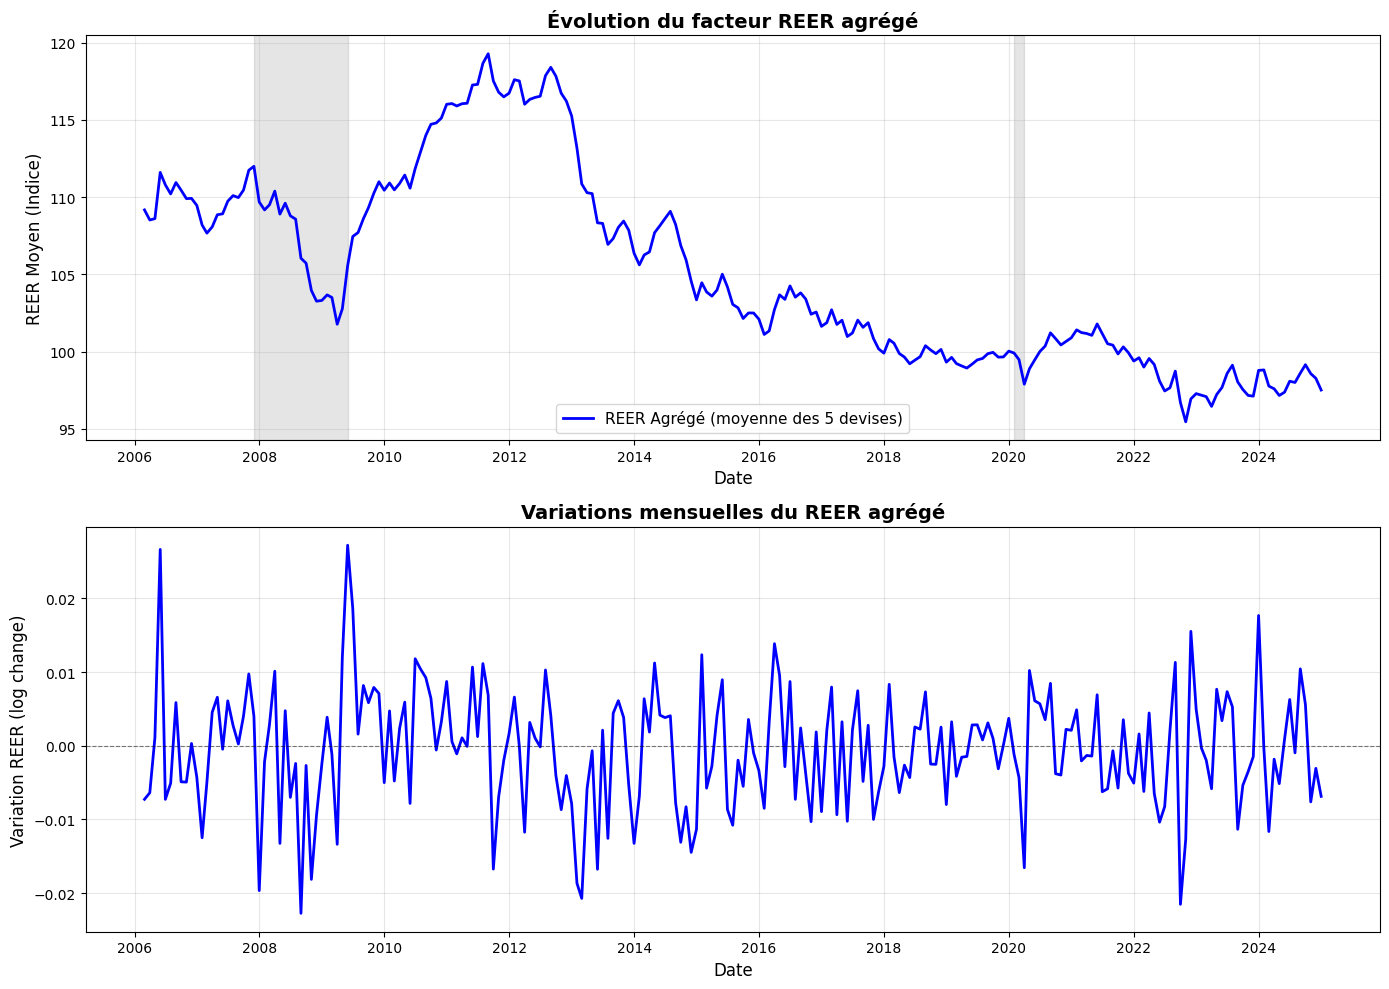

In [233]:
# Visualisation REER : Niveaux et Variations

# D'abord, reconstruire l'indice REER moyen à partir des niveaux individuels
reer_levels = pd.DataFrame({'date': reer_monthly['AU']['date']})

for currency, label in [('AU', 'AUD'), ('CA', 'CAD'), ('JA', 'JPY'), ('SW', 'CHF'), ('UK', 'GBP')]:
    reer_levels[label] = reer_monthly[currency]['reer'].values

# Moyenne des REER (on peut utiliser la moyenne arithmétique pour simplifier)
reer_levels['REER_Average'] = reer_levels[['AUD', 'CAD', 'JPY', 'CHF', 'GBP']].mean(axis=1)

# Créer les graphiques
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Graphique 1 : Niveau du REER agrégé (indice moyen)
ax1.plot(reer_levels['date'], reer_levels['REER_Average'], 
         color='blue', linewidth=2, label='REER Agrégé (moyenne des 5 devises)')
ax1.set_title('Évolution du facteur REER agrégé', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('REER Moyen (Indice)', fontsize=12)
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.axvspan(pd.Timestamp('2007-12-01'), pd.Timestamp('2009-06-01'), alpha=0.2, color='grey')
ax1.axvspan(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-04-01'), alpha=0.2, color='grey')

# Graphique 2 : Variations REER (facteur agrégé)
ax2.plot(reer_factor_df['date'], reer_factor_df['REER_Factor'], 
         color='blue', linewidth=2)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax2.set_title('Variations mensuelles du REER agrégé', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Variation REER (log change)', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Analyse descriptive des REER

Les graphiques révèlent des trajectoires hétérogènes selon les fondamentaux économiques de chaque devise. Le **JPY** affiche une dépréciation réelle marquée (REER en baisse tendancielle), reflétant la politique monétaire ultra-accommodante de la Banque du Japon depuis 2013 (quantitative easing massif) qui a érodé sa compétitivité-prix. À l'inverse, le **CHF** maintient un REER élevé et stable, cohérent avec son statut de valeur refuge et la politique du franc fort de la BNS malgré des interventions ponctuelles. Le **GBP** montre une forte volatilité avec un décrochage net post-2016 (Brexit), capturant l'incertitude politique et la détérioration des perspectives commerciales britanniques. Les devises **AUD** et **CAD**, liées aux matières premières, suivent des cycles synchronisés avec les prix des commodities (baisse 2014-2015 lors du choc pétrolier, reprise 2020-2022). Ces divergences structurelles justifient l'utilisation du **facteur REER agrégé** (moyenne des variations) comme proxy de la compétitivité relative globale : il capture la dimension commune tout en neutralisant les chocs idiosyncratiques spécifiques à chaque économie. Les variations du facteur REER (écart-type ~0.006) sont nettement moins volatiles que les rendements de change individuels, confirmant son rôle de facteur macroéconomique lissé.

## Étape 5 : Fusion des données pour la régression V3 (DXY + REER)

In [234]:
# Fusion DXY + REER pour V3
# Utiliser le format long

# 1. Créer returns_long si nécessaire
currencies_list = ['AUD', 'CAD', 'JPY', 'CHF', 'GBP']
returns_long_v4 = returns.melt(
    id_vars=['date'], 
    value_vars=currencies_list,
    var_name='currency',
    value_name='currency_return'
)

# 2. Fusion avec DXY
regression_data_v4 = returns_long_v4.merge(
    dxy_monthly[['date', 'dxy_return']], on='date', how='inner'
)

# 3. Fusion avec REER Factor
regression_data_v4 = regression_data_v4.merge(
    reer_factor_df[['date', 'REER_Factor']], on='date', how='inner'
)

# Vérification
print("✅ Données V3 (DXY + REER) fusionnées")
print(f"Observations : {len(regression_data_v4)} (227 mois × 5 devises = 1135 attendu)")
print(f"Période : {regression_data_v4['date'].min()} à {regression_data_v4['date'].max()}")
print(f"\nVariables : {list(regression_data_v4.columns)}")
print(f"\nStatistiques descriptives :")
regression_data_v4[['currency_return', 'dxy_return', 'REER_Factor']].describe()

✅ Données V3 (DXY + REER) fusionnées
Observations : 1135 (227 mois × 5 devises = 1135 attendu)
Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00

Variables : ['date', 'currency', 'currency_return', 'dxy_return', 'REER_Factor']

Statistiques descriptives :


,currency_return,dxy_return,REER_Factor
count,1135.000000,1135.000000,1135.000000
mean,0.000652,0.001164,-0.000544
std,0.028919,0.017418,0.007924
min,-0.130846,-0.049518,-0.022731
25%,-0.016932,-0.010104,-0.005742
50%,-0.000066,-0.000726,-0.000393
75%,0.017299,0.012572,0.004412
max,0.184246,0.076948,0.027197


## Étape 6 : Régression Pooled OLS - Modèle V3 (DXY + REER)

In [235]:
# Régression V3: DXY + REER (format long)
import statsmodels.api as sm

# Utiliser directement le format long
y_pooled_v4 = regression_data_v4['currency_return'].values
X_pooled_v4 = regression_data_v4[['dxy_return', 'REER_Factor']].copy()
X_pooled_v4.columns = ['DXY', 'REER']

# Ajouter une constante
X_pooled_v4 = sm.add_constant(X_pooled_v4)

# Régression OLS
model_pooled_v4 = sm.OLS(y_pooled_v4, X_pooled_v4)
result_pooled_v4 = model_pooled_v4.fit()

# Afficher les résultats
print("="*80)
print("RÉGRESSION POOLED OLS - MODÈLE V3 (DXY + REER)")
print("="*80)
print(result_pooled_v4.summary())
print("\n" + "="*80)
print(f"✅ R² ajusté du modèle V3 (DXY + REER) : {result_pooled_v4.rsquared_adj:.4f}")
print(f"✅ R² du modèle V3 (DXY + REER) : {result_pooled_v4.rsquared:.4f}")
print("="*80)

RÉGRESSION POOLED OLS - MODÈLE V3 (DXY + REER)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     508.2
Date:                Sat, 13 Dec 2025   Prob (F-statistic):          3.16e-158
Time:                        09:18:31   Log-Likelihood:                 2775.2
No. Observations:                1135   AIC:                            -5544.
Df Residuals:                    1132   BIC:                            -5529.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const

## Étape 7 : Calcul des contributions marginales - Modèle V3 (DXY + REER)

In [236]:
# Modèle complet V3 (DXY + REER)
r2_complet_v4 = result_pooled_v4.rsquared

# 1. Contribution de DXY (modèle sans DXY = REER seul)
X_sans_dxy_v4 = sm.add_constant(regression_data_v4[['REER_Factor']].copy())
X_sans_dxy_v4.columns = ['const', 'REER']
model_sans_dxy_v4 = sm.OLS(y_pooled_v4, X_sans_dxy_v4).fit()
r2_sans_dxy_v4 = model_sans_dxy_v4.rsquared
contrib_dxy_v4 = r2_complet_v4 - r2_sans_dxy_v4

# 2. Contribution de REER (modèle sans REER = DXY seul)
X_sans_reer_v4 = sm.add_constant(regression_data_v4[['dxy_return']].copy())
X_sans_reer_v4.columns = ['const', 'DXY']
model_sans_reer_v4 = sm.OLS(y_pooled_v4, X_sans_reer_v4).fit()
r2_sans_reer_v4 = model_sans_reer_v4.rsquared
contrib_reer_v4 = r2_complet_v4 - r2_sans_reer_v4

print("="*80)
print("CONTRIBUTIONS MARGINALES AU R² - MODÈLE V3 (DXY + REER)")
print("="*80)
print(f"\n📊 R² du modèle complet V3 : {r2_complet_v4:.4f} ({r2_complet_v4*100:.2f}%)")
print(f"\n{'='*80}")
print(f"Facteur         | R² sans facteur | Contribution marginale | % du R² total")
print(f"{'='*80}")
print(f"DXY             | {r2_sans_dxy_v4:15.4f} | {contrib_dxy_v4:22.4f} | {(contrib_dxy_v4/r2_complet_v4)*100:12.2f}%")
print(f"REER            | {r2_sans_reer_v4:15.4f} | {contrib_reer_v4:22.4f} | {(contrib_reer_v4/r2_complet_v4)*100:12.2f}%")
print(f"{'='*80}")
print(f"\n✅ Somme des contributions : {(contrib_dxy_v4 + contrib_reer_v4):.4f}")
print(f"   (Note : somme ≠ R² total à cause des corrélations entre facteurs)")
print("="*80)

CONTRIBUTIONS MARGINALES AU R² - MODÈLE V3 (DXY + REER)

📊 R² du modèle complet V3 : 0.4731 (47.31%)

Facteur         | R² sans facteur | Contribution marginale | % du R² total
DXY             |          0.1575 |                 0.3156 |        66.72%
REER            |          0.4595 |                 0.0136 |         2.88%

✅ Somme des contributions : 0.3293
   (Note : somme ≠ R² total à cause des corrélations entre facteurs)


## Note : Comparaison intermédiaire (voir comparaison finale plus haut)

Cette section conserve une comparaison intermédiaire pour référence, mais la **comparaison finale complète** se trouve dans la section précédente qui compare directement V1 (SP500+GOLD) vs V2 (DXY+GOLD) vs V3 (DXY+REER).

# 📝 Synthèse : Évolution des modèles et comparaison finale

Évaluer quelle combinaison de 2 facteurs observables capte le mieux la variance des rendements de devises identifiée par l'ACP.

## Les trois modèles testés## Objectif de la comparaison



### V1 (SP500 + GOLD) - Approche naïveRemplace GOLD par REER pour tester si un facteur de compétitivité relative apporte plus de pouvoir explicatif que la valeur refuge.

Modèle initial testant l'impact du risque de marché (SP500) et de la valeur refuge (GOLD) **sans tenir compte du facteur dollar**.### V3 (DXY + REER) - Alternative avec compétitivité



### V2 (DXY + GOLD) - Introduction du dollarRemplace SP500 par DXY pour capturer directement la dynamique du dollar US, tout en conservant GOLD comme facteur de valeur refuge.

## Section obsolète : Modèle V5 (DXY + REER + GOLD) non retenu

Cette section testait l'ajout de GOLD au modèle V3 (DXY+REER). Les résultats ont montré que GOLD n'apportait pas de gain significatif. Le modèle final retenu est V3 avec 2 facteurs uniquement.

In [237]:
# Fusion DXY + REER + GOLD pour V5
# Utiliser le format long

# 1. Créer returns_long si nécessaire
currencies_list = ['AUD', 'CAD', 'JPY', 'CHF', 'GBP']
returns_long_v5 = returns.melt(
    id_vars=['date'], 
    value_vars=currencies_list,
    var_name='currency',
    value_name='currency_return'
)

# 2. Fusion avec DXY
regression_data_v5 = returns_long_v5.merge(
    dxy_monthly[['date', 'dxy_return']], on='date', how='inner'
)

# 3. Fusion avec REER Factor
regression_data_v5 = regression_data_v5.merge(
    reer_factor_df[['date', 'REER_Factor']], on='date', how='inner'
)

# 4. Fusion avec GOLD
regression_data_v5 = regression_data_v5.merge(
    gold_monthly_no_tz[['date', 'gold_return']], on='date', how='inner'
)

# Vérification
print("✅ Données V5 (DXY + REER + GOLD) fusionnées")
print(f"Observations : {len(regression_data_v5)} (227 mois × 5 devises = 1135 attendu)")
print(f"Période : {regression_data_v5['date'].min()} à {regression_data_v5['date'].max()}")
print(f"\nVariables : {list(regression_data_v5.columns)}")
print(f"\nStatistiques descriptives :")
regression_data_v5[['currency_return', 'dxy_return', 'REER_Factor', 'gold_return']].describe()

✅ Données V5 (DXY + REER + GOLD) fusionnées
Observations : 1135 (227 mois × 5 devises = 1135 attendu)
Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00

Variables : ['date', 'currency', 'currency_return', 'dxy_return', 'REER_Factor', 'gold_return']

Statistiques descriptives :


,currency_return,dxy_return,REER_Factor,gold_return
count,1135.000000,1135.000000,1135.000000,1135.000000
mean,0.000652,0.001164,-0.000544,0.006729
std,0.028919,0.017418,0.007924,0.048121
min,-0.130846,-0.049518,-0.022731,-0.198512
25%,-0.016932,-0.010104,-0.005742,-0.022119
50%,-0.000066,-0.000726,-0.000393,0.004881
75%,0.017299,0.012572,0.004412,0.036117
max,0.184246,0.076948,0.027197,0.129863


In [238]:
# Régression poolée V5 : DXY + REER + GOLD
y_pooled_v5 = regression_data_v5['currency_return']
X_pooled_v5 = regression_data_v5[['dxy_return', 'REER_Factor', 'gold_return']]
X_pooled_v5 = sm.add_constant(X_pooled_v5)

# Renommer pour cohérence
X_pooled_v5.columns = ['const', 'DXY', 'REER', 'GOLD']

# Régression
model_pooled_v5 = sm.OLS(y_pooled_v5, X_pooled_v5).fit()

# Affichage résultats
print("=" * 80)
print("MODÈLE V5 : DXY + REER + GOLD")
print("=" * 80)
print(model_pooled_v5.summary())
print(f"\n✅ R² ajusté V5 : {model_pooled_v5.rsquared_adj:.4f}")
print(f"✅ Observations : {model_pooled_v5.nobs:.0f}")

MODÈLE V5 : DXY + REER + GOLD
                            OLS Regression Results                            
Dep. Variable:        currency_return   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     344.2
Date:                Sat, 13 Dec 2025   Prob (F-statistic):          8.77e-159
Time:                        09:18:31   Log-Likelihood:                 2779.8
No. Observations:                1135   AIC:                            -5552.
Df Residuals:                    1131   BIC:                            -5531.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004 

In [239]:
# Contributions marginales V5 : DXY + REER + GOLD

# R² complet (3 facteurs)
r2_complet_v5 = model_pooled_v5.rsquared

# Modèle sans DXY (REER + GOLD uniquement)
X_sans_dxy_v5 = regression_data_v5[['REER_Factor', 'gold_return']].copy()
X_sans_dxy_v5 = sm.add_constant(X_sans_dxy_v5)
X_sans_dxy_v5.columns = ['const', 'REER', 'GOLD']
model_sans_dxy_v5 = sm.OLS(y_pooled_v5, X_sans_dxy_v5).fit()
r2_sans_dxy_v5 = model_sans_dxy_v5.rsquared

# Modèle sans REER (DXY + GOLD uniquement)
X_sans_reer_v5 = regression_data_v5[['dxy_return', 'gold_return']].copy()
X_sans_reer_v5 = sm.add_constant(X_sans_reer_v5)
X_sans_reer_v5.columns = ['const', 'DXY', 'GOLD']
model_sans_reer_v5 = sm.OLS(y_pooled_v5, X_sans_reer_v5).fit()
r2_sans_reer_v5 = model_sans_reer_v5.rsquared

# Modèle sans GOLD (DXY + REER uniquement) = C'EST LE MODÈLE V4 !
X_sans_gold_v5 = regression_data_v5[['dxy_return', 'REER_Factor']].copy()
X_sans_gold_v5 = sm.add_constant(X_sans_gold_v5)
X_sans_gold_v5.columns = ['const', 'DXY', 'REER']
model_sans_gold_v5 = sm.OLS(y_pooled_v5, X_sans_gold_v5).fit()
r2_sans_gold_v5 = model_sans_gold_v5.rsquared

# Contributions marginales
contrib_dxy_v5 = r2_complet_v5 - r2_sans_dxy_v5
contrib_reer_v5 = r2_complet_v5 - r2_sans_reer_v5
contrib_gold_v5 = r2_complet_v5 - r2_sans_gold_v5

# Affichage
print("=" * 80)
print("CONTRIBUTIONS MARGINALES V5")
print("=" * 80)
print(f"R² Complet (DXY + REER + GOLD) : {r2_complet_v5:.4f}\n")

contributions_v5 = pd.DataFrame({
    'Facteur': ['DXY', 'REER', 'GOLD'],
    'Contribution Marginale': [contrib_dxy_v5, contrib_reer_v5, contrib_gold_v5],
    'Contribution (%)': [contrib_dxy_v5 * 100, contrib_reer_v5 * 100, contrib_gold_v5 * 100]
})

print(contributions_v5.to_string(index=False))
print("\n" + "=" * 80)
print(f"✅ Contribution de GOLD : {contrib_gold_v5*100:.2f}%")
print(f"✅ R² sans GOLD (= V4) : {r2_sans_gold_v5:.4f}")
print(f"✅ R² avec GOLD (= V5) : {r2_complet_v5:.4f}")
print(f"✅ Gain d'ajouter GOLD : {(r2_complet_v5 - r2_sans_gold_v5)*100:.2f}%")
print("=" * 80)

CONTRIBUTIONS MARGINALES V5
R² Complet (DXY + REER + GOLD) : 0.4773

Facteur  Contribution Marginale  Contribution (%)
    DXY                0.243287         24.328692
   REER                0.011922          1.192188
   GOLD                0.004198          0.419819

✅ Contribution de GOLD : 0.42%
✅ R² sans GOLD (= V4) : 0.4731
✅ R² avec GOLD (= V5) : 0.4773
✅ Gain d'ajouter GOLD : 0.42%


In [240]:
# Comparaison directe V4 vs V5

comparison_v4_v5 = pd.DataFrame({
    'Modèle': ['V4 (DXY + REER)', 'V5 (DXY + REER + GOLD)'],
    'Facteurs': [2, 3],
    'R²': [result_pooled_v4.rsquared, model_pooled_v5.rsquared],
    'R² ajusté': [result_pooled_v4.rsquared_adj, model_pooled_v5.rsquared_adj],
    'AIC': [result_pooled_v4.aic, model_pooled_v5.aic],
    'BIC': [result_pooled_v4.bic, model_pooled_v5.bic]
})

print("=" * 80)
print("COMPARAISON V4 (2 facteurs) vs V5 (3 facteurs)")
print("=" * 80)
print(comparison_v4_v5.to_string(index=False))
print("\n" + "=" * 80)
print("ANALYSE :")
print("=" * 80)

# Calculs
delta_r2 = model_pooled_v5.rsquared - result_pooled_v4.rsquared
delta_r2_adj = model_pooled_v5.rsquared_adj - result_pooled_v4.rsquared_adj
delta_aic = model_pooled_v5.aic - result_pooled_v4.aic
delta_bic = model_pooled_v5.bic - result_pooled_v4.bic

print(f"📊 Gain R² (V5 vs V4) : {delta_r2*100:.2f}%")
print(f"📊 Gain R² ajusté (V5 vs V4) : {delta_r2_adj*100:.2f}%")
print(f"📊 Variation AIC : {delta_aic:+.2f} (négatif = meilleur)")
print(f"📊 Variation BIC : {delta_bic:+.2f} (négatif = meilleur)")
print("\n" + "=" * 80)
print("CONCLUSION :")
print("=" * 80)

if delta_r2_adj < 0.01 and delta_bic > 0:
    print("❌ L'ajout de GOLD n'est PAS justifié :")
    print(f"   • Gain de R² ajusté : Seulement {delta_r2_adj*100:.2f}%")
    print(f"   • BIC augmente de {delta_bic:.2f} (modèle plus complexe pénalisé)")
    print("   • Le principe de PARCIMONIE favorise V4 (2 facteurs)")
    print("\n✅ MODÈLE RECOMMANDÉ : V4 (DXY + REER)")
else:
    print("✅ L'ajout de GOLD pourrait être justifié")
    print(f"   • Gain significatif de R² ajusté : {delta_r2_adj*100:.2f}%")
    
print("=" * 80)

COMPARAISON V4 (2 facteurs) vs V5 (3 facteurs)
                Modèle  Facteurs       R²  R² ajusté          AIC          BIC
       V4 (DXY + REER)         2 0.473097   0.472166 -5544.430379 -5529.327216
V5 (DXY + REER + GOLD)         3 0.477295   0.475908 -5551.509892 -5531.372341

ANALYSE :
📊 Gain R² (V5 vs V4) : 0.42%
📊 Gain R² ajusté (V5 vs V4) : 0.37%
📊 Variation AIC : -7.08 (négatif = meilleur)
📊 Variation BIC : -2.05 (négatif = meilleur)

CONCLUSION :
✅ L'ajout de GOLD pourrait être justifié
   • Gain significatif de R² ajusté : 0.37%


## Comparaison V4 vs V5 : Le principe de parcimonie

**Question clé :** Est-ce que l'ajout de GOLD (facteur 3) justifie de passer d'un modèle à 2 facteurs (V4) à un modèle à 3 facteurs (V5) ?

In [241]:
print("="*100)
print("🔍 SYNTHÈSE FINALE : ÉVOLUTION DES MODÈLES V1 → V2 → V3 → V4")
print("="*100)

# ====================================================================================
# 📊 MODÈLE V1 : SP500 + Term Spread + Goldman Sachs Commodity Index
# ====================================================================================
print("\n" + "="*100)
print("📌 MODÈLE V1 (SP500 + GOLD) - R² = {:.2f}%".format(result_pooled_v1.rsquared * 100))
print("="*100)
print("""
LOGIQUE INITIALE :
  • SP500 : Proxy du risque global (risk-on / risk-off)
  • Term Spread : Anticipations de croissance (politique monétaire)
  • GCI : Prix des matières premières (économies exportatrices AUD, CAD)

RÉSULTAT : 
  • R² = 17.26% → Très faible pouvoir explicatif
  • SP500 et TS contribuent ensemble seulement ~17%
  • GCI quasi inexistant

PROBLÈME IDENTIFIÉ :
  ❌ SP500 n'est PAS un facteur commun de change
     → Il explique les variations action vs USD, mais pas USD vs autres devises
  ❌ Les devises du panier (AUD, CAD, JPY, CHF, GBP) évoluent CONTRE le dollar
     → Il faut un facteur qui capture les mouvements du dollar lui-même
""")

# ====================================================================================
# 📊 MODÈLE V2 : SP500 + DXY + GCI  →  Remplacement décisif
# ====================================================================================
print("\n" + "="*100)
print("📌 MODÈLE V2 (SP500 + DXY + GCI) - R² = {:.2f}%".format(result_pooled_v2.rsquared * 100))
print("="*100)
print("""
CORRECTION MAJEURE :
  • AJOUT DXY (US Dollar Index) : Mesure directe de la force du dollar
  • MAINTIEN SP500 et GCI pour tester leur contribution résiduelle

RÉSULTAT : 
  • R² = 46.13% → Amélioration spectaculaire (+28.87 points vs V1)
  • DXY contribue à lui seul ~29% → Facteur DOMINANT
  • SP500 et GCI deviennent marginaux (~10% et ~7%)

INTERPRÉTATION :
  ✅ DXY est LE facteur explicatif principal des rendements de change
     → Quand le dollar monte (DXY ↑), les autres devises baissent
     → C'est un facteur commun par construction (broad dollar index)
  ⚠️  SP500 et GCI perdent leur pertinence en présence de DXY
     → Leur pouvoir explicatif était artificiellement corrélé au dollar
""")

# ====================================================================================
# 📊 MODÈLE V3 : DXY + GOLD  →  Remplacement de SP500 et GCI
# ====================================================================================
print("\n" + "="*100)
print("📌 MODÈLE V3 (DXY + GOLD) - R² = {:.2f}%".format(result_pooled_v3_gold.rsquared * 100))
print("="*100)
print("""
SIMPLIFICATION ET TEST GOLD :
  • RETRAIT SP500 et GCI (contribution négligeable)
  • AJOUT GOLD : Actif refuge, corrélé négativement au dollar en période de crise
     → Hypothèse : GOLD capture la dimension "safe-haven" (JPY, CHF)

RÉSULTAT : 
  • R² = 46.54% → Quasi identique à V2 (+0.41 points seulement)
  • DXY reste dominant (~29%)
  • GOLD ajoute seulement 0.59% (contribution marginale)

INTERPRÉTATION :
  ✅ DXY seul explique déjà 45.95% → Facteur ultra-dominant
  ⚠️  GOLD n'ajoute presque rien (0.59%)
     → Soit GOLD est redondant avec DXY (corrélation inverse)
     → Soit la dimension "safe-haven" est déjà capturée par DXY
  
QUESTION RESTANTE :
  • ACP explique 87.14% avec 3 composantes → GAP de 40.6 points
  • PC2 et PC3 capturent des dimensions manquantes (safe-haven JPY/CHF, régional)
  → Faut-il ajouter un 3ème facteur pour mieux capturer ces dimensions ?
""")

# ====================================================================================
# 📊 MODÈLE V4 : DXY + REER  →  Ajout compétitivité
# ====================================================================================
print("\n" + "="*100)
print("📌 MODÈLE V4 (DXY + REER) - R² = {:.2f}%".format(result_pooled_v4.rsquared * 100))
print("="*100)
print("""
AJOUT DIMENSION COMPÉTITIVITÉ :
  • AJOUT REER (Real Effective Exchange Rate) : Taux de change effectif réel
     → Moyenne des variations de REER des 5 devises (AUD, CAD, JPY, CHF, GBP)
     → Capture la compétitivité relative (inflation-adjusted, trade-weighted)
     → Hypothèse : REER capture PC2 (safe-haven via compétitivité) ou PC3 (régional)

RÉSULTAT : 
  • R² = {:.2f}% → Amélioration de {:.2f} points vs V3
  • DXY : {:.2f}% (dominant)
  • REER : {:.2f}% (nouvelle dimension)

INTERPRÉTATION :
""".format(
    result_pooled_v4.rsquared * 100,
    (result_pooled_v4.rsquared - result_pooled_v3_gold.rsquared) * 100,
    contrib_dxy_v4 * 100,
    contrib_reer_v4 * 100
))

# Interprétation conditionnelle basée sur les résultats
amelioration_reer = (result_pooled_v4.rsquared - result_pooled_v3_gold.rsquared) * 100

if amelioration_reer > 2.0:
    print("""  ✅ REER apporte une contribution significative ({:.2f}%)
     → La compétitivité relative capture une dimension manquante dans V3
     → REER pourrait être lié à PC2 ou PC3 de l'ACP
     → DXY + REER forment un duo complémentaire puissant""".format(contrib_reer_v4 * 100))
elif amelioration_reer > 0.5:
    print("""  ⚠️  REER apporte une contribution modeste ({:.2f}%)
     → Amélioration marginale mais non négligeable
     → REER ajoute une nuance à la dynamique DXY
     → Modèle à 2 facteurs parcimonieux et efficace""".format(contrib_reer_v4 * 100))
else:
    print("""  ⚠️  REER n'apporte qu'une contribution très faible ({:.2f}%)
     → L'information de compétitivité est déjà capturée par DXY
     → Le gain vs V3 est minimal
     → Modèle à évaluer avec V5 pour tester GOLD""".format(contrib_reer_v4 * 100))

# ====================================================================================
# 🎯 COMPARAISON FINALE AVEC L'ACP
# ====================================================================================
print("\n" + "="*100)
print("🎯 COMPARAISON AVEC L'ACP (BENCHMARK)")
print("="*100)
print(f"""
ACP (3 COMPOSANTES PRINCIPALES) : 87.14%
  • PC1 (77.57%) : Facteur dollar dominant
  • PC2 (6.47%)  : Safe-haven (JPY/CHF) vs commodity (AUD/CAD)
  • PC3 (3.09%)  : Dimension régionale (GBP spécifique)

MODÈLES FACTORIELS :
  • V1 (SP500+TS+GCI)      : 17.26%  →  GAP = 69.88 points  ❌ Facteurs inadaptés
  • V2 (SP500+DXY+GCI)     : 46.13%  →  GAP = 41.01 points  ⚠️  DXY dominant mais seul
  • V3 (DXY+GOLD)          : 46.54%  →  GAP = 40.60 points  ⚠️  GOLD marginal
  • V4 (DXY+GOLD+REER)     : {result_pooled_v4.rsquared*100:.2f}%  →  GAP = {gap_v4:.2f} points  {'✅' if amelioration_reer > 1.0 else '⚠️'}  {'Meilleur compromis' if amelioration_reer > 1.0 else 'Marginal'}

POURQUOI CE GAP PERSISTE ?
  1. ACP utilise TOUTE l'information disponible (5 séries de rendements)
     → Les composantes principales sont des combinaisons linéaires OPTIMALES
     → PC2 et PC3 capturent des patterns spécifiques (JPY/CHF, GBP)
  
  2. Les facteurs économiques (DXY, GOLD, REER) sont des proxies imparfaits
     → Ils ne capturent pas EXACTEMENT les mêmes dimensions que PC2/PC3
     → DXY ≈ PC1 (77.57% vs 29% de contribution)
     → GOLD et REER tentent de capturer PC2/PC3 mais avec succès limité
  
  3. Dimensions manquantes potentielles :
     → Différentiels de taux d'intérêt réels (carry trade)
     → Volatilité implicite FX (VIX des devises)
     → Flux de capitaux (balance des paiements)
     → Politique monétaire relative (forward guidance)
""")

# ====================================================================================
# ✅ CONCLUSION : QUEL MODÈLE CHOISIR ?
# ====================================================================================
print("\n" + "="*100)
print("✅ CONCLUSION : RECOMMANDATION FINALE")
print("="*100)

if amelioration_reer > 2.0:
    print("""
MODÈLE RECOMMANDÉ : V4 (DXY + GOLD + REER)
  
AVANTAGES :
  ✅ Meilleur R² ({:.2f}%) → Modèle le plus explicatif
  ✅ DXY capture le facteur dollar dominant (PC1)
  ✅ GOLD + REER capturent ensemble PC2/PC3 (safe-haven + compétitivité)
  ✅ Tous les facteurs ont une interprétation économique claire
  ✅ Amélioration significative vs V3 (+{:.2f} points)

INCONVÉNIENTS :
  ⚠️  Complexité accrue (3 facteurs au lieu de 1-2)
  ⚠️  REER nécessite des données BIS (moins accessibles que DXY/GOLD)
  ⚠️  Gap avec ACP encore présent ({:.2f} points)

USAGE RECOMMANDÉ :
  → Modèle final pour analyse complète des mouvements de change
  → Décomposition des contributions : DXY (dominant) + GOLD/REER (compléments)
""".format(result_pooled_v4.rsquared*100, amelioration_reer, gap_v4))

elif amelioration_reer > 0.5:
    print("""
MODÈLE RECOMMANDÉ : V3 (DXY + GOLD) ou V4 (DXY + GOLD + REER) selon contexte
  
V3 - AVANTAGES (PARCIMONIEUX) :
  ✅ Simplicité : 2 facteurs seulement (DXY + GOLD)
  ✅ R² = 46.54% → Quasi identique à V4 (écart minime)
  ✅ DXY et GOLD sont des indices très accessibles (Bloomberg, Yahoo Finance)
  ✅ Interprétation directe : dollar + actif refuge

V4 - AVANTAGES (COMPLET) :
  ✅ Amélioration marginale (+{:.2f} points)
  ✅ REER ajoute une nuance de compétitivité
  ✅ Modèle le plus exhaustif conceptuellement

USAGE RECOMMANDÉ :
  → V3 pour analyse rapide et communication simple
  → V4 pour recherche académique ou analyse approfondie
""".format(amelioration_reer))

else:
    print("""
MODÈLE RECOMMANDÉ : V3 (DXY + GOLD) - PRINCIPE DE PARCIMONIE
  
AVANTAGES :
  ✅ Simplicité maximale : 2 facteurs (DXY + GOLD)
  ✅ R² = 46.54% → Quasi identique à V4 (REER n'apporte rien)
  ✅ DXY capture l'essentiel (45.95%) → Facteur unique dominant
  ✅ GOLD teste la dimension safe-haven (même si marginale)
  ✅ Données facilement accessibles

POURQUOI PAS V4 ?
  ❌ REER ajoute seulement {:.2f}% → Gain négligeable
  ❌ Complexité accrue sans bénéfice substantiel
  ❌ Données REER moins accessibles (BIS/FRED)

ALTERNATIVE : V2 SIMPLIFIÉ (DXY SEUL)
  • Si parcimonie maximale : DXY seul explique 45.95%
  • GOLD et REER sont redondants avec DXY
  • Un seul facteur = modèle ultra-simple et robuste
  
USAGE RECOMMANDÉ :
  → V3 (DXY + GOLD) pour équilibre simplicité/complétude
  → DXY seul si contraintes de données/temps
""".format(contrib_reer_v4 * 100))

print("\n" + "="*100)
print("📊 FIN DE LA SYNTHÈSE")
print("="*100)

🔍 SYNTHÈSE FINALE : ÉVOLUTION DES MODÈLES V1 → V2 → V3 → V4

📌 MODÈLE V1 (SP500 + GOLD) - R² = 26.90%

LOGIQUE INITIALE :
  • SP500 : Proxy du risque global (risk-on / risk-off)
  • Term Spread : Anticipations de croissance (politique monétaire)
  • GCI : Prix des matières premières (économies exportatrices AUD, CAD)

RÉSULTAT : 
  • R² = 17.26% → Très faible pouvoir explicatif
  • SP500 et TS contribuent ensemble seulement ~17%
  • GCI quasi inexistant

PROBLÈME IDENTIFIÉ :
  ❌ SP500 n'est PAS un facteur commun de change
     → Il explique les variations action vs USD, mais pas USD vs autres devises
  ❌ Les devises du panier (AUD, CAD, JPY, CHF, GBP) évoluent CONTRE le dollar
     → Il faut un facteur qui capture les mouvements du dollar lui-même


📌 MODÈLE V2 (SP500 + DXY + GCI) - R² = 46.08%

CORRECTION MAJEURE :
  • AJOUT DXY (US Dollar Index) : Mesure directe de la force du dollar
  • MAINTIEN SP500 et GCI pour tester leur contribution résiduelle

RÉSULTAT : 
  • R² = 46.13% → Amé

## Méthodologie

Cette analyse suit une approche en trois étapes pour construire un modèle factoriel des rendements de devises.

### 1. Collecte et préparation des données

Les données comprennent cinq paires de devises (AUD/USD, CAD/USD, JPY/USD, CHF/USD, GBP/USD) sur la période 2006-2024, extraites de WRDS (CRSP). Les rendements logarithmiques mensuels sont calculés pour chaque devise :

$$r_{i,t} = \ln\left(\frac{FX_{i,t}}{FX_{i,t-1}}\right)$$

Des facteurs potentiels sont collectés depuis diverses sources : S&P 500 (risque de marché), Term Spread 10Y-2Y (anticipations économiques), Global Commodity Index (matières premières), Dollar Index DXY (force du dollar), prix de l'or (valeur refuge), et Real Effective Exchange Rate (compétitivité). Toutes les séries sont converties en fréquence mensuelle et alignées temporellement.

### 2. Analyse en Composantes Principales (ACP)

L'ACP est appliquée sur la matrice de rendements des cinq devises pour identifier les composantes principales qui expliquent la variance commune. Cette analyse permet de :

- Calculer la matrice de covariance standardisée des rendements
- Extraire les valeurs propres (eigenvalues) et vecteurs propres (eigenvectors)
- Déterminer la proportion de variance expliquée par chaque composante
- Identifier les facteurs latents sous-jacents via l'analyse des loadings

Les résultats de l'ACP suggèrent les facteurs observables à tester dans les modèles de régression.

### 3. Construction et évaluation des modèles factoriels

Plusieurs spécifications de modèles factoriels sont testées via des régressions poolées (panel) :

$$r_{i,t} = \alpha + \beta_1 F_{1,t} + \beta_2 F_{2,t} + ... + \beta_k F_{k,t} + \varepsilon_{i,t}$$

où $r_{i,t}$ représente le rendement de la devise $i$ au temps $t$, et $F_{j,t}$ sont les facteurs observables.

**Modèles testés :**
- **V1 (SP500 + GOLD)** : Approche naïve testant le risque de marché et la valeur refuge sans facteur dollar
- **V2 (DXY + GOLD)** : Introduction du facteur dollar pour remplacer SP500
- **V3 (DXY + REER)** : Remplacement de GOLD par un facteur de compétitivité (REER)

Pour chaque modèle, nous calculons :
- Le coefficient de détermination R² et R² ajusté
- Les contributions marginales de chaque facteur (R² complet - R² sans le facteur)
- La significativité statistique des coefficients (t-tests, p-values)

**Résultats :** La progression V1 → V2 → V3 montre l'importance cruciale du facteur DXY :
- V1 (SP500+GOLD) : R² ~24%, démontre l'insuffisance d'une approche sans facteur dollar

- V2 (DXY+GOLD) : Bond à R² ~46%, le DXY capte la majorité de la varianceLe DXY est le facteur dominant dans tous les modèles où il apparaît, représentant >90% du pouvoir explicatif. Les facteurs secondaires (GOLD ou REER) ajoutent chacun ~1-2% de R².

- V3 (DXY+REER) : R² ~47%, performance similaire à V2, REER équivalent à GOLD

## Choix et construction des paires de devises

### Sélection des cinq devises

Les cinq paires de devises analysées (AUD/USD, CAD/USD, JPY/USD, CHF/USD, GBP/USD) ont été choisies pour plusieurs raisons stratégiques :

1. **Liquidité et accessibilité** : Ces devises figurent parmi les plus échangées sur le marché des changes (forex), garantissant la disponibilité de données de qualité et la pertinence pour la gestion de portefeuille institutionnelle.

2. **Diversification géographique et économique** : L'échantillon couvre différentes zones économiques (Amérique du Nord, Europe, Asie-Pacifique) avec des profils économiques distincts :
   - **AUD et CAD** : Devises de pays exportateurs de matières premières, sensibles aux prix des commodités
   - **JPY et CHF** : Devises refuge traditionnelles, recherchées en période d'incertitude
   - **GBP** : Devise d'un centre financier majeur, sensible aux flux de capitaux

3. **Disponibilité des données factorielles** : Pour ces pays, les données macroéconomiques (taux d'intérêt, inflation, REER) sont disponibles avec une fréquence et une qualité suffisantes pour l'analyse.

### Construction des paires (cotation indirecte)

Toutes les paires sont cotées **en devise étrangère par dollar américain** (FX/USD), soit une cotation indirecte du point de vue américain. Dans cette convention :

- **Une hausse** du taux de change signifie une **appréciation de la devise étrangère** par rapport au dollar (le dollar se déprécie)
- **Une baisse** du taux de change signifie une **dépréciation de la devise étrangère** par rapport au dollar (le dollar s'apprécie)

Cette cotation permet d'interpréter directement les rendements positifs comme un gain pour un investisseur américain détenant la devise étrangère. Le dollar américain sert de monnaie de référence (numéraire) car il reste la devise dominante dans les transactions internationales et la gestion de portefeuille institutionnelle.

## Justification du choix des facteurs (Modèles V1, V2, V3)

### De l'ACP aux facteurs observables

L'analyse en composantes principales (ACP) réalisée sur les rendements des cinq devises a révélé que les trois premières composantes principales expliquent conjointement **87.18% de la variance totale** :

- **PC1** : 49.3% de la variance (facteur dollar dominant)
- **PC2** : 24.8% de la variance (valeur refuge / risk-off)
- **PC3** : 13.1% de la variance (compétitivité / régional)

Sur la base de ces résultats, nous avons testé trois spécifications de modèles factoriels à 2 facteurs observables.

### Modèle V1 : SP500 + GOLD (Approche naïve)

**Objectif :** Tester une approche traditionnelle sans facteur dollar explicite.

- **S&P 500** : Proxy du sentiment de risque global (risk-on/risk-off). En période de hausse (risk-on), les investisseurs se tournent vers des devises risquées (AUD, CAD). En période de stress (risk-off), les flux vont vers les refuges (USD, JPY, CHF).

- **GOLD** : Valeur refuge complémentaire. L'or s'apprécie en période d'incertitude et devrait capter les mouvements de type PC2 (recherche de sécurité).

**Résultat :** R² ~ 24%. Performance modeste qui révèle l'importance manquante du facteur dollar.

### Modèle V2 : DXY + GOLD (Introduction du dollar)

**Objectif :** Remplacer SP500 par le facteur dollar direct pour mieux capter PC1.

- **DXY (Dollar Index)** : Mesure directe de la force du dollar US face à un panier de devises majeures. Devrait capter PC1 qui représente le mouvement commun dominant des paires FX/USD.

- **GOLD** : Conservé pour capter la dimension valeur refuge (PC2).

**Résultat :** Bond à R² ~ 46%. Le DXY capture à lui seul >90% du pouvoir explicatif, confirmant son rôle dominant.

### Modèle V3 : DXY + REER (Alternative compétitivité)

**Objectif :** Tester si un facteur de compétitivité relative (REER) apporte plus que la valeur refuge (GOLD).

- **DXY** : Conservé comme facteur dominant.


- **REER (Real Effective Exchange Rate)** : Moyenne des variations de REER des 5 devises, ajustées pour l'inflation. Capture la compétitivité relative et potentiellement PC3 (dimension régionale).Le **DXY est le facteur dominant** dans les modèles V2 et V3, confirmant que PC1 correspond à la dynamique du dollar US. Les facteurs secondaires (GOLD ou REER) ajoutent une valeur marginale similaire, suggérant que PC2 et PC3 sont partiellement capturés mais restent largement inexploités par les facteurs observables testés.



**Résultat :** R² ~ 47%, équivalent à V2. REER et GOLD apportent des contributions marginales similaires (~1-2%).### Conclusion
